# Exploring Neural Operators Package

# Datasets

## Example 1: A simple Darcy-Flow dataset


In [7]:
import matplotlib.pyplot as plt
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.layers.embeddings import GridEmbedding2D
import urllib.request
import os

In [8]:
def download(
    url : str,
    local_filename : str = None
):
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

base_url = 'https://www.github.com/neuraloperator/neuraloperator/raw/refs/heads/main/neuralop/data/datasets/data/'
download(os.path.join(base_url, 'darcy_test_32.pt'))
download(os.path.join(base_url, 'darcy_test_16.pt'))
download(os.path.join(base_url, 'darcy_train_16.pt'))

train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
        data_root='./',
)

device = 'cpu'
data_processor = data_processor.to(device)

train_dataset = train_loader.dataset

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:122: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  data["x"][train_input_indices].unsqueeze(channel_dim).type(torch.float32).clone()
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:125: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in

16
Testing samples for res 16 have shape torch.Size([1, 16, 16])
32
Testing samples for res 32 have shape torch.Size([1, 32, 32])
Training samples have shape torch.Size([16, 16])


c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\eamor\AppData\Local\Temp\ipykernel_95404\2688208138.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


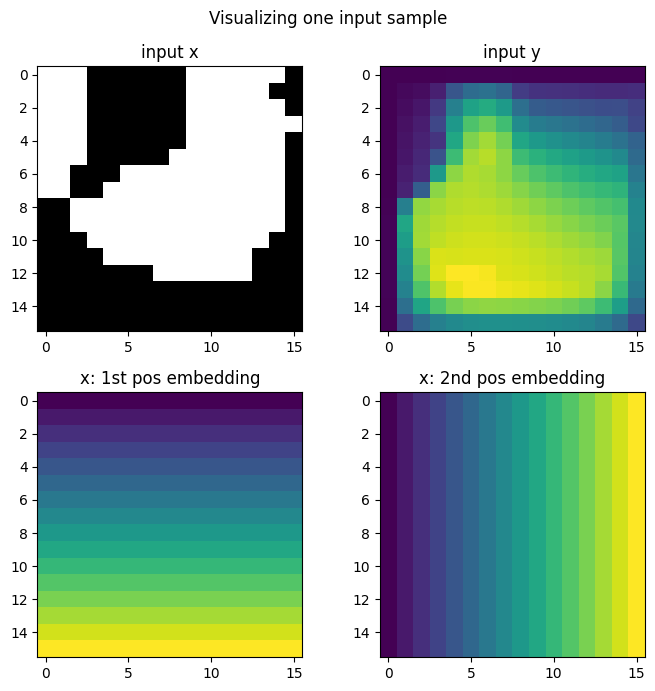

In [ ]:
for res, test_loader in test_loaders.items():
    print(res)
    # Get first batch
    batch = next(iter(test_loader))
    x = batch['x']
    y = batch['y']

    print(f'Testing samples for res {res} have shape {x.shape[1:]}')


data = train_dataset[0]
x = data['x']
y = data['y']

print(f'Training samples have shape {x.shape[1:]}')


# Which sample to view
index = 0

data = train_dataset[index]
data = data_processor.preprocess(data, batched=False)

# The first step of the default FNO model is a grid-based
# positional embedding. We will add it manually here to
# visualize the channels appended by this embedding.
positional_embedding = GridEmbedding2D(in_channels=1)
# at train time, data will be collated with a batch dim.
# we create a batch dim to pass into the embedding, then re-squeeze
x = positional_embedding(data['x'].unsqueeze(0)).squeeze(0)
y = data['y']

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x')

ax = fig.add_subplot(2, 2, 2)
ax.imshow(y.squeeze())
ax.set_title('input y')

ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax.set_title('x: 1st pos embedding')

ax = fig.add_subplot(2, 2, 4)
ax.imshow(x[2])
ax.set_title('x: 2nd pos embedding')

fig.suptitle('Visualizing one input sample', y=0.98)
plt.tight_layout()
fig.show()

these are 4 plots representing the way that positional embeddings work.
- Plot 1: input x
- Plot 2: output y with positional embedding
- Plot 3: first channel of positional embedding (x[1] / x)
- Plot 4: second channel of positional embedding (x[2] / y)

## Example 2: A simple Darcy-Flow spectrum analysis

In [10]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from neuralop.utils import spectrum_2d
from neuralop.data.datasets import load_darcy_flow_small

font = {'size'   : 28}
matplotlib.rc('font', **font)

torch.manual_seed(0)
np.random.seed(0)

In [11]:
T = 500 # number of time steps
samples = 50
s = 16 # resolution of the dataset

# additional paramaters for the dataset
Re = 5000
index = 1
T = 100
dataset_name = "Darcy Flow"

In [17]:
def download(
    url : str,
    local_filename : str = None
):
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

base_url = 'https://www.github.com/neuraloperator/neuraloperator/raw/refs/heads/main/neuralop/data/datasets/data/'
download(os.path.join(base_url, 'darcy_test_32.pt'))
download(os.path.join(base_url, 'darcy_test_16.pt'))
download(os.path.join(base_url, 'darcy_train_16.pt'))

train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=50, batch_size=50,
        test_resolutions=[16, 32], n_tests=[50, 50],
        test_batch_sizes=[32],
        encode_output=False,
        data_root='./',
)

device = 'cpu'
data_processor = data_processor.to(device)

# This is highly depending on your dataset and its structure ['x', 'y'] (In Darcy flow)
print("Original dataset shape", train_loader.dataset[:samples]['x'].shape) # check the shape

# It is important to note that we want the last two dimensions to represent the spatial dimensions
# So in some cases one might have to permute the dataset after squeezing the initial dimensions as well
dataset_pred = train_loader.dataset[:samples]['x'].squeeze() # squeeze the dataset to remove the empty channel dimension

# Shape of the dataset
shape = dataset_pred.shape

# Define the grid size - in our case its a 2d Grid repeating, for higher dimensions this will change
# Example for 3d grid
"""
batchsize, size_x, size_y, size_z = 1, shape[0], shape[1], shape[2]
gridx = torch.tensor(np.linspace(-1, 1, size_x), dtype=torch.float)
gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
gridy = torch.tensor(np.linspace(-1, 1, size_y), dtype=torch.float)
gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
gridz = torch.tensor(np.linspace(-1, 1, size_z), dtype=torch.float)
gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
grid = torch.cat((gridx, gridy, gridz), dim=-1)
"""
batchsize, size_x, size_y = 1, shape[1], shape[2]
gridx = torch.tensor(np.linspace(-1, 1, size_x), dtype=torch.float)
gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, size_y])
gridy = torch.tensor(np.linspace(-1, 1, size_y), dtype=torch.float)
gridy = gridy.reshape(1, 1, size_y).repeat([batchsize, size_x, 1])
grid = torch.cat((gridx, gridy), dim=-1)

Loading test db for resolution 16 with 50 samples 
Loading test db for resolution 32 with 50 samples 
Original dataset shape torch.Size([50, 1, 16, 16])


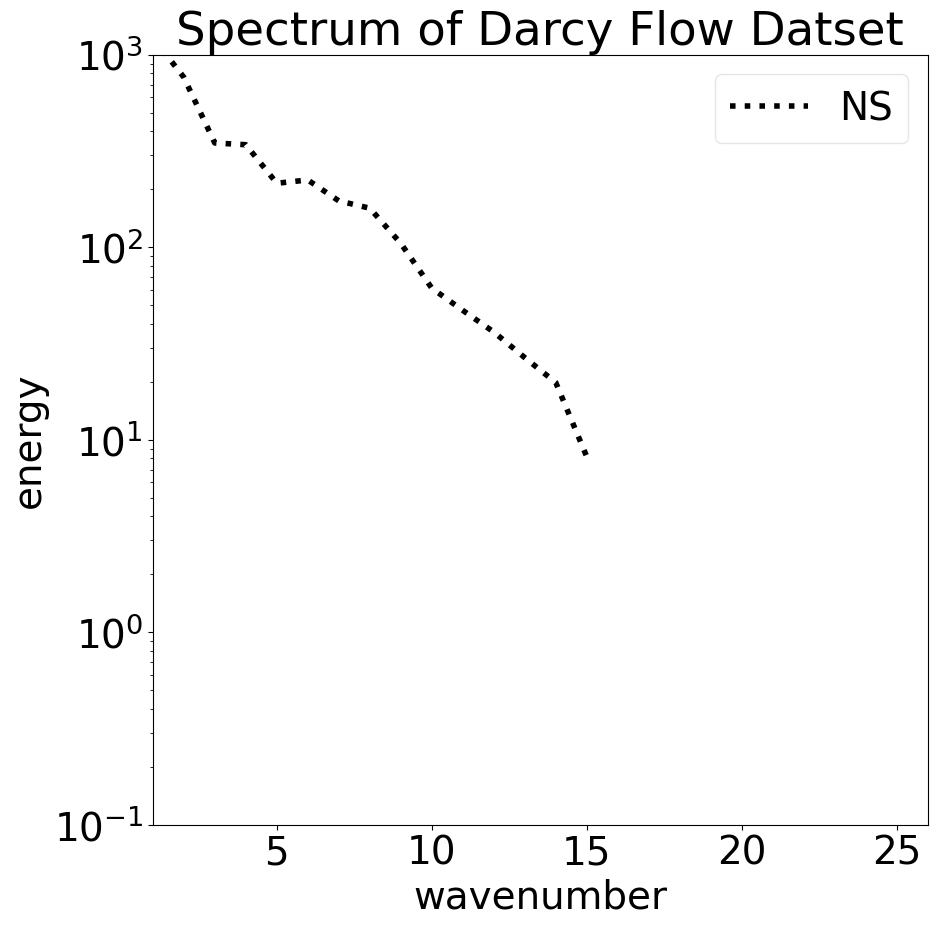

In [19]:
# Generate the spectrum of the dataset
# We reshape our samples into the form expected by ``spectrum_2d``: ``(n_samples, h, w)``
truth_sp = spectrum_2d(dataset_pred.reshape(samples * batchsize, s, s), s)

# Configure pyplot and generate the plot
fig, ax = plt.subplots(figsize=(10,10))

linewidth = 3
ax.set_yscale('log')

length = dataset_pred.shape[-1] # the resolution length of the dataset
buffer = 10 # just add a buffer to the plot
k = np.arange(length + buffer) * 1.0
ax.plot(truth_sp, 'k', linestyle=":", label="NS", linewidth=4)

ax.set_xlim(1,length+buffer)
ax.set_ylim(0.1, 1000)
plt.legend(prop={'size': 20})
plt.title('Spectrum of {} Datset'.format(dataset_name))

plt.xlabel('wavenumber')
plt.ylabel('energy')

# show the figure
leg = plt.legend(loc='best')
leg.get_frame().set_alpha(0.5)
plt.show()

# Data Generation

## Example 4: A simple finite-difference solver

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class FiniteDiff:
    def __init__(self, dim=2, h=(1.0, 1.0)):
        self.dim = dim
        if isinstance(h, (float, int)):
            self.h = (h,) * dim
        else:
            self.h = h

    def dx(self, u):
        """Compute first derivative in x using central differences."""
        h = self.h[0]
        # Roll tensor for periodic boundary conditions
        return (torch.roll(u, -1, dims=-2) - torch.roll(u, 1, dims=-2)) / (2 * h)

    def dy(self, u):
        """Compute first derivative in y using central differences."""
        h = self.h[1]
        return (torch.roll(u, -1, dims=-1) - torch.roll(u, 1, dims=-1)) / (2 * h)

    def dxx(self, u):
        """Compute second derivative in x using central differences."""
        h = self.h[0]
        return (torch.roll(u, -1, dims=-2) - 2 * u + torch.roll(u, 1, dims=-2)) / (h ** 2)

    def dyy(self, u):
        """Compute second derivative in y using central differences."""
        h = self.h[1]
        return (torch.roll(u, -1, dims=-1) - 2 * u + torch.roll(u, 1, dims=-1)) / (h ** 2)

In [6]:
## Simulation parameters
Lx, Ly = 2.0, 2.0   # Domain lengths
nx, ny = 64, 64   # Grid resolution
T = 1.6    # Total simulation time
dt = 0.001  # Time step
nu = 0.02   # diffusion coefficient
cx, cy = 1.0, 0.6  # advection speeds

## Create grid
X = torch.linspace(0, Lx, nx, device=device).repeat(ny, 1).T
Y = torch.linspace(0, Ly, ny, device=device).repeat(nx, 1)
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
nt = int(T / dt)

## Initialize finite difference operator
fd = FiniteDiff(dim=2, h=(dx, dy))


## Initial condition and source term
u = (-torch.sin(2 * np.pi * Y) * torch.cos(2 * np.pi * X)
        + 0.3 * torch.exp(-((X - 0.75)**2 + (Y - 0.5)**2) / 0.02)
        - 0.3 * torch.exp(-((X - 1.25)**2 + (Y - 1.5)**2) / 0.02)).to(device)

def source_term(X, Y, t):
    return 0.2 * torch.sin(3 * np.pi * X) * torch.cos(3 * np.pi * Y) * torch.cos(4 * np.pi * t)

In [7]:
u_evolution = [u.clone()]

t = torch.tensor(0.0)
for _ in range(nt):

    # Compute derivatives
    u_x = fd.dx(u)
    u_y = fd.dy(u)
    u_xx = fd.dx(u_x)
    u_yy = fd.dy(u_y)

    # Evolve one step in time using Euler's method
    u = u + dt * (-cx * u_x - cy * u_y + nu * (u_xx + u_yy) + source_term(X, Y, t))
    t += dt
    u_evolution.append(u.clone())

u_evolution = torch.stack(u_evolution).cpu().numpy()

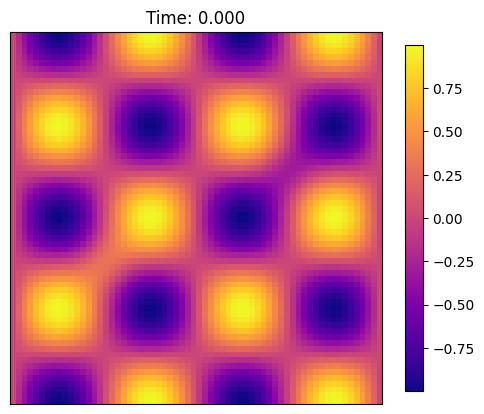

In [11]:
num_frames = 100
frame_indices = torch.linspace(0, len(u_evolution) - 1, num_frames, dtype=torch.int).cpu().numpy()
u_frames = u_evolution[frame_indices]

fig, ax = plt.subplots(figsize=(6, 6))
cmap_u = ax.imshow(u_frames[0], extent=[0, Lx, 0, Ly], origin="lower", cmap="plasma")
ax.set_title("Advection-Diffusion: u")
plt.colorbar(cmap_u, ax=ax, shrink=0.75)

def update(frame):
    cmap_u.set_data(u_frames[frame])
    ax.set_title(f"Time: {frame_indices[frame] * dt:.3f}")
    ax.set_xticks([])
    ax.set_yticks([])
    return cmap_u,

ani = animation.FuncAnimation(fig, update, frames=len(u_frames), interval=50, blit=False)
ani.save("advection_diffusion_simulation.gif", writer="pillow")

## Example 5: A Numerical Solver for Burgers’ Equation in 2 Dimensions


$$ u_t + u \cdot u_x + v \cdot u_y = \nu (u_{xx} + u_{yy})$$

$$ v_t + u \cdot v_x + v \cdot v_y = \nu (v_{xx} + v_{yy})$$

where $u$ and $v$ are the velocity components in the $x$ and $y$ directions, respectively, and $\nu$ is the kinematic viscosity.


In [12]:
## Simulation parameters
Lx, Ly = 2.0, 2.0   # Domain lengths
nx, ny = 64, 64   # Grid resolution
T = 1    # Total simulation time
dt = 0.001  # Time step
nu = 0.04   # Viscosity

## Create grid
X = torch.linspace(0, Lx, nx, device=device).repeat(ny, 1).T
Y = torch.linspace(0, Ly, ny, device=device).repeat(nx, 1)
dx = Lx / (nx-1)
dy = Ly / (ny-1)
nt = int(T / dt)

## Initialize finite difference operator
fd = FiniteDiff(dim=2, h=(dx, dy))

## Initial condition
u = -torch.sin(2 * np.pi * Y).to(device)
v =  torch.cos(2 * np.pi * X).to(device)

In [13]:
u_evolution = [u.clone()]
v_evolution = [v.clone()]

for _ in range(nt):

    # Compute first-order derivatives
    u_x = fd.dx(u)
    u_y = fd.dy(u)
    v_x = fd.dx(v)
    v_y = fd.dy(v)

    # Compute second-order derivatives
    u_xx = fd.dx(u_x)
    u_yy = fd.dy(u_y)
    v_xx = fd.dx(v_x)
    v_yy = fd.dy(v_y)

    # Evolve in time using Euler's method
    u_next = u + dt * (-u * u_x - v * u_y + nu * (u_xx + u_yy))
    v_next = v + dt * (-u * v_x - v * v_y + nu * (v_xx + v_yy))

    u, v = u_next.clone(), v_next.clone()
    u_evolution.append(u.clone())
    v_evolution.append(v.clone())

u_evolution = torch.stack(u_evolution).cpu().numpy()
v_evolution = torch.stack(v_evolution).cpu().numpy()

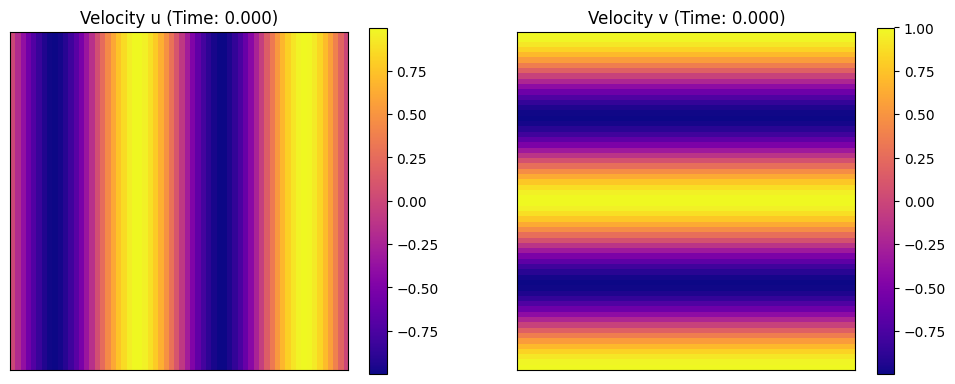

In [15]:
num_frames = 100
frame_indices = torch.linspace(0, len(u_evolution) - 1, num_frames, dtype=torch.int).cpu().numpy()
u_frames = u_evolution[frame_indices]
v_frames = v_evolution[frame_indices]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
cmap_u = axs[0].imshow(u_frames[0], extent=[0, Lx, 0, Ly], origin="lower", cmap="plasma")
axs[0].set_title("Velocity u")
plt.colorbar(cmap_u, ax=axs[0], shrink=0.75)
cmap_v = axs[1].imshow(v_frames[0], extent=[0, Lx, 0, Ly], origin="lower", cmap="plasma")
axs[1].set_title("Velocity v")
plt.colorbar(cmap_v, ax=axs[1], shrink=0.75)

def update(frame):
    cmap_u.set_data(u_frames[frame])
    cmap_v.set_data(v_frames[frame])
    axs[0].set_title(f"Velocity u (Time: {frame_indices[frame] * dt:.3f})")
    axs[1].set_title(f"Velocity v (Time: {frame_indices[frame] * dt:.3f})")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    return cmap_u, cmap_v

ani = animation.FuncAnimation(fig, update, frames=len(u_frames), interval=50, blit=False)
ani.save("2d_burgers.gif", writer="pillow")

# Layers

## Example 6: Visualizing neighbor search

In [17]:
import random
import matplotlib.pyplot as plt
import torch

from neuralop.layers.gno_block import GNOBlock
from neuralop.layers.neighbor_search import native_neighbor_search
from neuralop.layers.embeddings import regular_grid_2d

Many problems involve data collected over irregular point clouds. The Graph Neural Operator (GNO) is a simple neural operator architecture that learns a map between functions evaluated on (potentially different) arbitrary point clouds. For a set of input coordinates Y, an input function f evaluated at all y ∈ Y, and a set of output coordinates X, our goal is to map to a new function g evaluated at all x ∈ X. To do so, the GNO computes the Nyström approximation of a continuous kernel integral by summing the values of f across a neighborhood of each point x drawn from the input coordinates Y (with an optional kernel k): int_{N_r(x)} f(y) k(x,y) dy

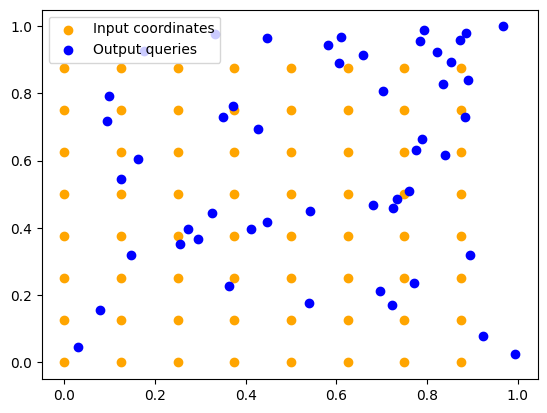

In [26]:
input_coords = torch.stack(regular_grid_2d(spatial_dims=(8,8))).permute(1,2,0).view(-1,2) #reshape into (64, 2)
output_queries = torch.rand([50, 2])

plt.scatter(input_coords[:, 0], input_coords[:, 1], color='orange', label="Input coordinates")
plt.scatter(output_queries[:, 0], output_queries[:, 1], color='blue', label="Output queries")
plt.legend()

(0.0, 1.0)

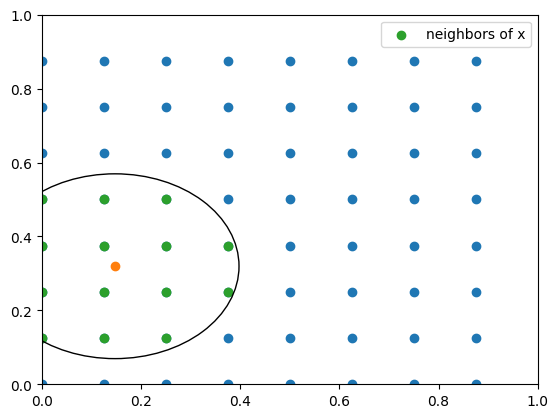

In [29]:
query_index = 28
query_point = output_queries[query_index]
# Let's search, assuming a radius of 0.25. Note that this is quite high for the density of our data.
# in practice we tend to use values that find on the order of 10 neighbors.
nbr_data = native_neighbor_search(data=input_coords, queries=query_point.unsqueeze(0), radius=0.25)
fig, ax = plt.subplots()
neighbors = input_coords[nbr_data['neighbors_index']]
ax.scatter(input_coords[:, 0], input_coords[:, 1])
ax.scatter(query_point[0], query_point[1])
ax.scatter(neighbors[:, 0], neighbors[:, 1], label="neighbors of x")
c = plt.Circle(query_point, radius=0.25, fill=False)
ax.add_patch(c)
ax.legend()
ax.set_xlim(0,1)
ax.set_ylim(0,1)

## Example 7: Grid embeddings

In [ ]:
import random
import matplotlib.pyplot as plt
import torch

device = 'cpu'

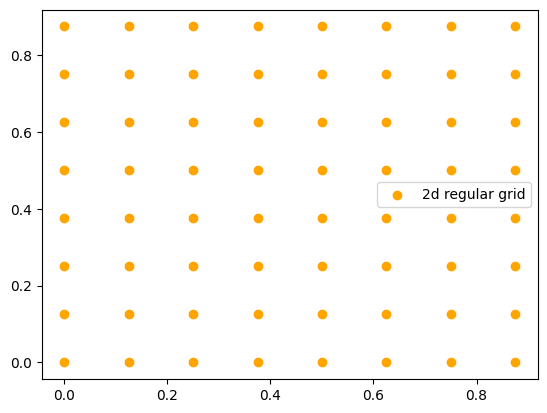

In [30]:
from neuralop.layers.embeddings import regular_grid_2d
grid_2d = torch.stack(regular_grid_2d(spatial_dims=(8,8))).permute(1,2,0).view(-1,2) #reshape into (64, 2)

plt.scatter(grid_2d[:, 0], grid_2d[:, 1], color='orange', label="2d regular grid")
plt.legend()

c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:122: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  data["x"][train_input_indices].unsqueeze(channel_dim).type(torch.float32).clone()
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:125: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in

Loading test db for resolution 16 with 16 samples 
Loading test db for resolution 32 with 16 samples 
One batch of x is of shape: torch.Size([2, 1, 16, 16])
After embedding, x is of shape: torch.Size([2, 3, 16, 16])


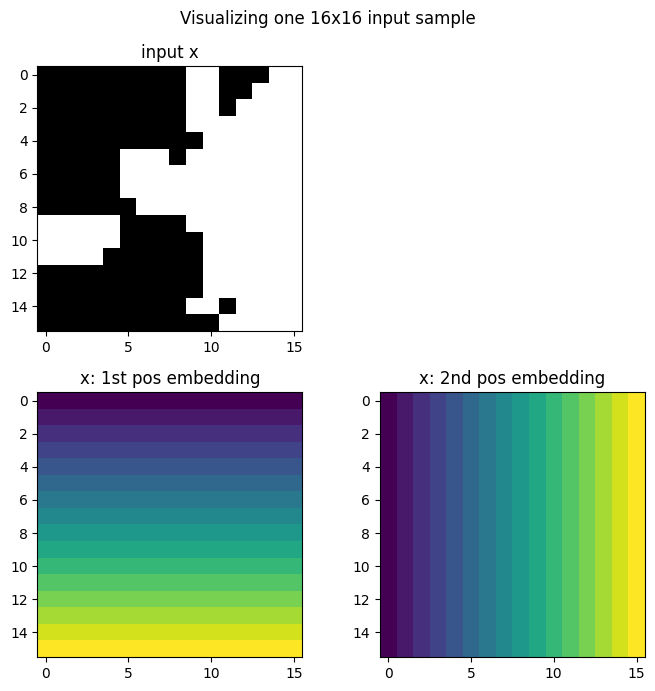

In [32]:
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.layers.embeddings import GridEmbedding2D

_, test_loaders, _ = load_darcy_flow_small(
        n_train=10, batch_size=1,
        test_resolutions=[16, 32], n_tests=[16, 16],
        test_batch_sizes=[2, 2],
        encode_output=False,
        data_root='./'
)

loader_16 = test_loaders[16]
example = next(iter(loader_16))
x = example['x']
print(f"One batch of x is of shape: {x.shape}")

# Note: our Darcy dataset is generated on the unit square, but our grid
# embedding's boundaries are configurable.
grid_embedding = GridEmbedding2D(in_channels=1, grid_boundaries=[[0,1], [0,1]])
x = grid_embedding(x)
print(f"After embedding, x is of shape: {x.shape}")

# grab the first element of the batch
x = x[0]
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x')
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax.set_title('x: 1st pos embedding')
ax = fig.add_subplot(2, 2, 4)
ax.imshow(x[2])
ax.set_title('x: 2nd pos embedding')
fig.suptitle('Visualizing one 16x16 input sample', y=0.98)
plt.tight_layout()
fig.show()

One batch of x is of shape: torch.Size([2, 1, 32, 32])
After embedding, x is of shape: torch.Size([2, 3, 32, 32])


C:\Users\eamor\AppData\Local\Temp\ipykernel_41656\3559633879.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


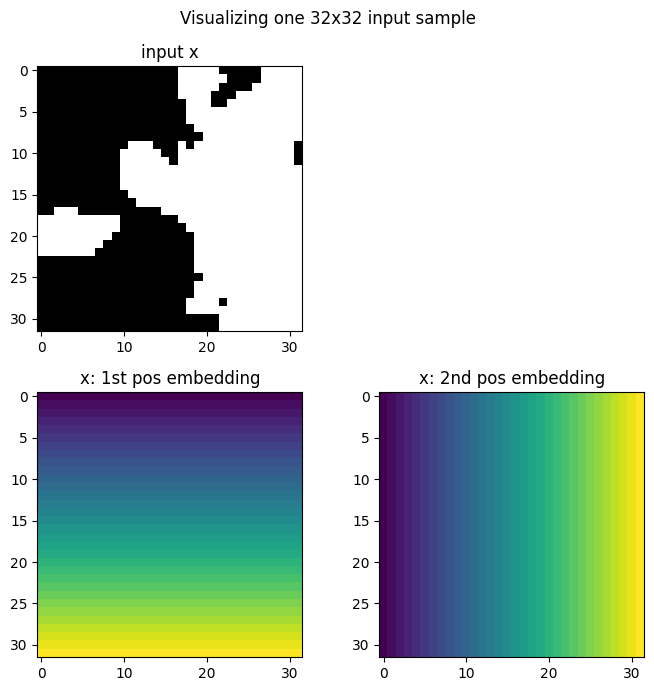

In [33]:
loader_32 = test_loaders[32]
example = next(iter(loader_32))
x = example['x']
print(f"One batch of x is of shape: {x.shape}")

x = grid_embedding(x)
print(f"After embedding, x is of shape: {x.shape}")

# grab the first element of the batch
x = x[0]
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x')
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax.set_title('x: 1st pos embedding')
ax = fig.add_subplot(2, 2, 4)
ax.imshow(x[2])
ax.set_title('x: 2nd pos embedding')
fig.suptitle('Visualizing one 32x32 input sample', y=0.98)
plt.tight_layout()
fig.show()

Text(0.5, 0, 'Z')

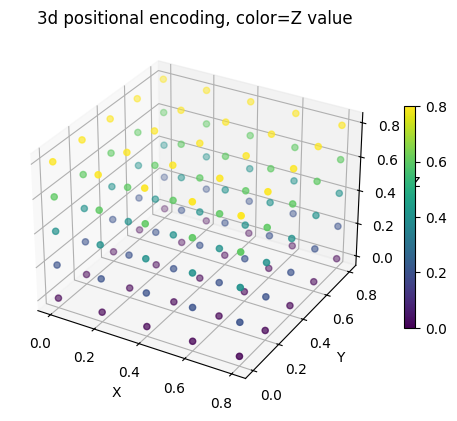

In [34]:
from neuralop.layers.embeddings import GridEmbeddingND
cube_len = 5
x = torch.randn(1, 1, cube_len, cube_len, cube_len)
embedding_3d = GridEmbeddingND(in_channels=1, dim=3, grid_boundaries=[[0,1]]*3)

x = embedding_3d(x)
# grab only the appended positional embedding channels
x = x[0,1:,...].permute(1,2,3,0).view(-1, 3)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plot = ax.scatter(x[:,0], x[:, 1], x[:, 2], c=x[:, 2])
fig.colorbar(plot, ax=ax, shrink=0.6)
ax.set_title("3d positional encoding, color=Z value")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

## Example 8: Visualizing discrete-continuous convolutions

In [35]:
import os
import torch
import torch.nn as nn
import numpy as np
import math
from functools import partial

from matplotlib import image

from torch_harmonics.quadrature import legendre_gauss_weights, lobatto_weights, clenshaw_curtiss_weights

import matplotlib.pyplot as plt

cmap="inferno"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from neuralop.layers.discrete_continuous_convolution import DiscreteContinuousConv2d, DiscreteContinuousConvTranspose2d, EquidistantDiscreteContinuousConv2d, EquidistantDiscreteContinuousConvTranspose2d

Let’s start by loading an example image

C:\Users\eamor\AppData\Local\Temp\ipykernel_41656\1807986515.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  data = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(ny,nx)).squeeze()


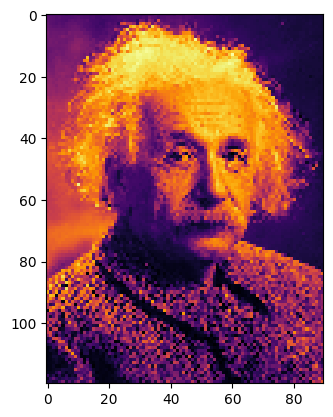

In [37]:
os.system("curl https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Albert_Einstein_Head.jpg/360px-Albert_Einstein_Head.jpg -o ./einstein.jpg")

nx = 90
ny = 120

img = image.imread('./einstein.jpg')
data = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(ny,nx)).squeeze()
plt.imshow(data, cmap=cmap)
plt.show()

Let’s create a grid on which the data lives

In [38]:
x_in = torch.linspace(0, 2, nx)
y_in = torch.linspace(0, 3, ny)

x_in, y_in = torch.meshgrid(x_in, y_in, indexing='ij')
grid_in = torch.stack([x_in.reshape(-1), y_in.reshape(-1)])

# compute the correct quadrature weights
# IMPORTANT: this needs to be done right in order for the DISCO convolution to be normalized proeperly
w_x = 2*torch.ones_like(x_in) / nx
w_y = 3*torch.ones_like(y_in) / ny
q_in = (w_x * w_y).reshape(-1)

Visualize the grid

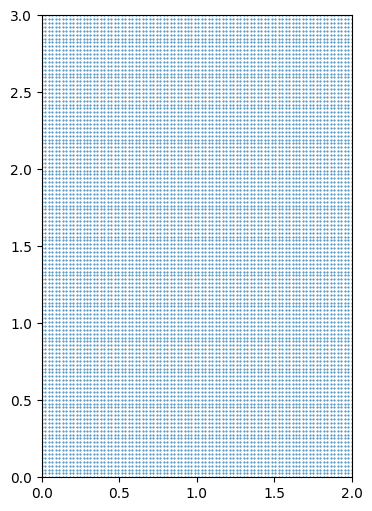

In [39]:
plt.figure(figsize=(4,6), )
plt.scatter(grid_in[0], grid_in[1], s=0.2)
plt.xlim(0,2)
plt.ylim(0,3)
plt.show()

Format data into the same format and plot it on the grid

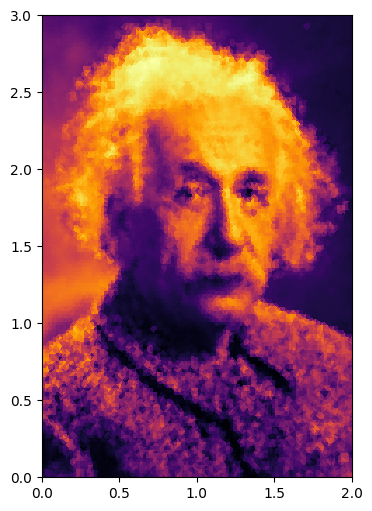

In [40]:
data = data.permute(1,0).flip(1).reshape(-1)

plt.figure(figsize=(4,6), )
plt.tripcolor(grid_in[0], grid_in[1], data, cmap=cmap)
# plt.colorbar()
plt.xlim(0,2)
plt.ylim(0,3)
plt.show()

For the convolution output we require an output mesh

In [41]:
nxo = 90
nyo = 120

x_out = torch.linspace(0, 2, nxo)
y_out = torch.linspace(0, 3, nyo)

x_out, y_out = torch.meshgrid(x_out, y_out, indexing='ij')
grid_out = torch.stack([x_out.reshape(-1), y_out.reshape(-1)])

# compute the correct quadrature weights
w_x = 2*torch.ones_like(x_out) / nxo
w_y = 3*torch.ones_like(y_out) / nyo
q_out = (w_x * w_y).reshape(-1)

Initialize the convolution and set the weights to something resembling an edge filter/finite differences

In [43]:
conv = DiscreteContinuousConv2d(1, 1, grid_in=grid_in, grid_out=grid_out, quadrature_weights=q_in, kernel_shape=[2,4], radius_cutoff=5/nyo, periodic=False).float()

# initialize a kernel resembling an edge filter
w = torch.zeros_like(conv.weight)
w[0,0,1] = 1.0
w[0,0,3] = -1.0
conv.weight = nn.Parameter(w)
psi = conv.get_local_filter_matrix()

in order to compute the convolved image, we need to first bring it into the right shape with batch_size x n_channels x n_grid_points

torch.Size([1, 1, 10800])


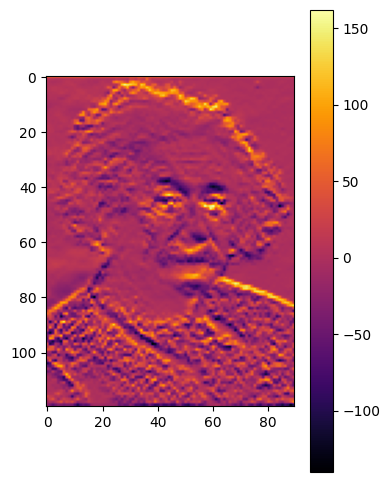

In [44]:
out = conv(data.reshape(1, 1, -1))

print(out.shape)

plt.figure(figsize=(4,6), )
plt.imshow(torch.flip(out.squeeze().detach().reshape(nxo, nyo).transpose(0,1), dims=(-2, )), cmap=cmap)
plt.colorbar()
plt.show()

out1 = torch.flip(out.squeeze().detach().reshape(nxo, nyo).transpose(0,1), dims=(-2, ))

torch.Size([1, 1, 119, 89])


c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


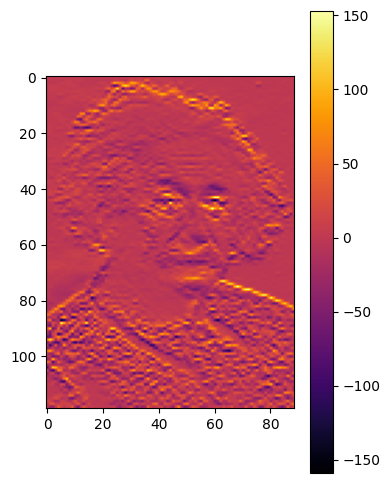

torch.Size([119, 89])


In [45]:
conv_equi = EquidistantDiscreteContinuousConv2d(1, 1, (nx, ny), (nxo, nyo), kernel_shape=[2,4], radius_cutoff=5/nyo, domain_length=[2,3])

# initialize a kernel resembling an edge filter
w = torch.zeros_like(conv.weight)
w[0,0,1] = 1.0
w[0,0,3] = -1.0
conv_equi.weight = nn.Parameter(w)

data = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(ny,nx)).float()

out_equi = conv_equi(data)

print(out_equi.shape)

plt.figure(figsize=(4,6), )
plt.imshow(out_equi.squeeze().detach(), cmap=cmap)
plt.colorbar()
plt.show()

out2 = out_equi.squeeze().detach()

print(out2.shape)

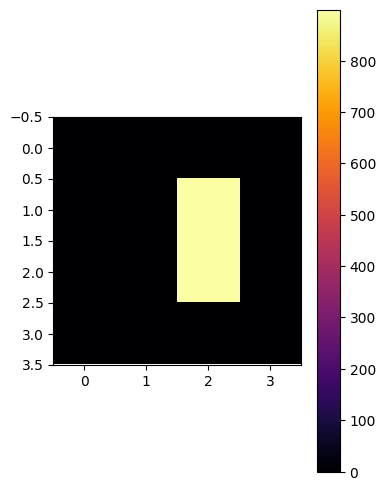

In [46]:
plt.figure(figsize=(4,6), )
plt.imshow(conv_equi.get_local_filter_matrix()[0].detach(), cmap=cmap)
plt.colorbar()


torch.Size([1, 1, 10800])


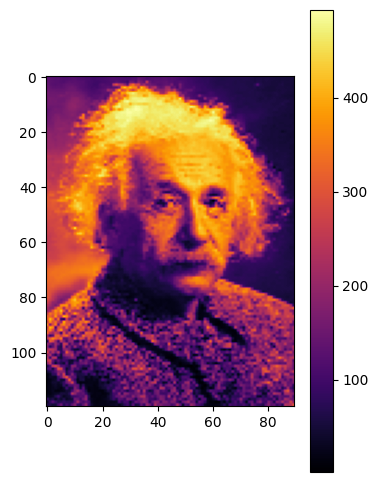

In [47]:
convt = DiscreteContinuousConvTranspose2d(1, 1, grid_in=grid_out, grid_out=grid_in, quadrature_weights=q_out, kernel_shape=[2,4], radius_cutoff=3/nyo, periodic=False).float()

# initialize a flat
w = torch.zeros_like(conv.weight)
w[0,0,0] = 1.0
w[0,0,1] = 1.0
w[0,0,2] = 1.0
w[0,0,3] = 1.0
convt.weight = nn.Parameter(w)

data = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(ny,nx)).squeeze().float().permute(1,0).flip(1).reshape(-1)
out = convt(data.reshape(1, 1, -1))

print(out.shape)

plt.figure(figsize=(4,6), )
plt.imshow(torch.flip(out.squeeze().detach().reshape(nx, ny).transpose(0,1), dims=(-2, )), cmap=cmap)
plt.colorbar()
plt.show()

torch.Size([1, 1, 120, 90])


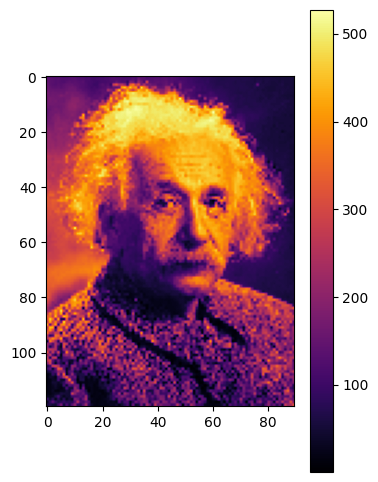

In [48]:
convt_equi = EquidistantDiscreteContinuousConvTranspose2d(1, 1, (nxo, nyo), (nx, ny), kernel_shape=[2,4], radius_cutoff=3/nyo, domain_length=[2,3])

# initialize a flat
w = torch.zeros_like(convt_equi.weight)
w[0,0,0] = 1.0
w[0,0,1] = 1.0
w[0,0,2] = 1.0
w[0,0,3] = 1.0
convt_equi.weight = nn.Parameter(w)

data = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(nyo,nxo)).float()
out_equi = convt_equi(data)

print(out_equi.shape)

plt.figure(figsize=(4,6), )
plt.imshow(out_equi.squeeze().detach(), cmap=cmap)
plt.colorbar()
plt.show()


## Example 9: Fourier Differentiation

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [119]:
import torch
import torch.fft

class FourierDiff:
    """
    Computes spectral derivatives for 1D, 2D, or nD periodic data using FFTs.
    Optionally supports non-periodic domains with Legendre-based correction (placeholder).
    """
    def __init__(self, dim=1, L=None, use_fc=False, fc_degree=4, fc_n_additional_pts=50):
        """
        Args:
            dim (int): number of spatial dimensions.
            L (float or tuple): domain lengths for each dimension.
            use_fc (str or bool): optional finite correction type ('Legendre' or False).
            fc_degree (int): polynomial degree for Legendre correction.
            fc_n_additional_pts (int): extra points for non-periodic correction.
        """
        self.dim = dim
        if isinstance(L, (int, float, torch.Tensor)):
            self.L = [float(L)] * dim
        else:
            self.L = [float(l) for l in L]
        self.use_fc = use_fc
        self.fc_degree = fc_degree
        self.fc_n_additional_pts = fc_n_additional_pts

    def _get_freqs(self, shape):
        """Compute angular frequencies for each dimension."""
        freqs = []
        for i, n in enumerate(shape[-self.dim:]):
            k = torch.fft.fftfreq(n, d=self.L[i] / n).to(torch.float32)
            freqs.append(2 * torch.pi * k)
        return freqs

    def _apply_derivative(self, f, deriv_orders):
        """
        Apply spectral differentiation of given derivative orders.
        f: (..., Nx, Ny, ...) tensor.
        deriv_orders: list of derivative orders for each dimension (e.g., [1,0] for df/dx).
        """
        # Compute FFT
        F = torch.fft.fftn(f, dim=tuple(range(-self.dim, 0)))

        freqs = self._get_freqs(f.shape)
        for axis, (order, w) in enumerate(zip(deriv_orders, freqs)):
            if order == 0:
                continue
            # reshape frequency vector for broadcasting
            shape = [1] * f.ndim
            shape[-self.dim + axis] = len(w)
            w = w.reshape(shape).to(f.device)
            F = F * ((1j * w) ** order)

        # Inverse FFT to return derivative
        return torch.fft.ifftn(F, dim=tuple(range(-self.dim, 0))).real

    def compute_multiple_derivatives(self, f, orders):
        """
        Compute multiple derivative orders for all dims (e.g., [1,2]).
        f: tensor of shape (..., Nx[, Ny, ...])
        orders: list of derivative orders to compute (e.g., [1,2,3])
        """
        results = []
        for n in orders:
            # For 1D, this is just d^n/dx^n
            deriv_orders = [n] + [0]*(self.dim-1)
            results.append(self._apply_derivative(f, deriv_orders))
        return results

    def dx(self, f): return self._apply_derivative(f, [1, 0] if self.dim > 1 else [1])
    def dy(self, f): return self._apply_derivative(f, [0, 1])
    def dz(self, f): return self._apply_derivative(f, [0, 0, 1])
    def laplacian(self, f):
        """Compute ∇²f = sum of second derivatives along all dimensions."""
        result = 0
        for axis in range(self.dim):
            deriv_orders = [0]*self.dim
            deriv_orders[axis] = 2
            result += self._apply_derivative(f, deriv_orders)
        return result


Creating an example of periodic 1D curve
Here we consider sin(x) and cos(x), which are periodic on the interval [0, 2π]

In [86]:
L = 2 * torch.pi
x = torch.linspace(0, L, 101)[:-1]
f = torch.stack([torch.sin(x), torch.cos(x)], dim=0)
x_np = x.cpu().numpy()

Differentiate the signal
We use the FourierDiff class to differentiate the signal

In [87]:
fd1d = FourierDiff(dim=1, L=L, use_fc=False)
derivatives = fd1d.compute_multiple_derivatives(f, [1, 2, 3])
dfdx, df2dx2, df3dx3 = derivatives

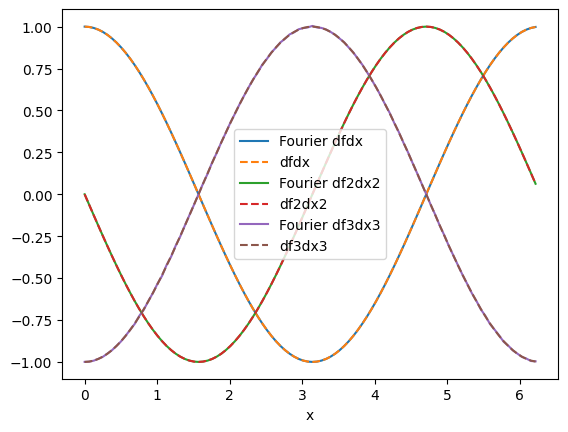

In [88]:
plt.figure()
plt.plot(x_np, dfdx[0].squeeze().cpu().numpy(), label='Fourier dfdx')
plt.plot(x_np, np.cos(x_np), '--', label='dfdx')
plt.plot(x_np, df2dx2[0].squeeze().cpu().numpy(), label='Fourier df2dx2')
plt.plot(x_np, -np.sin(x_np), '--', label='df2dx2')
plt.plot(x_np, df3dx3[0].squeeze().cpu().numpy(), label='Fourier df3dx3')
plt.plot(x_np, -np.cos(x_np), '--', label='df3dx3')
plt.xlabel('x')
plt.legend()
plt.show()

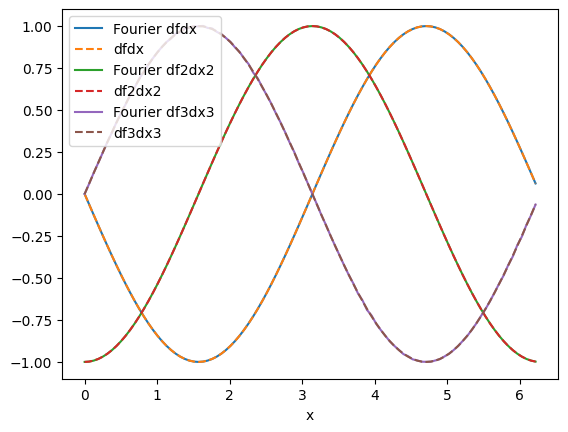

In [89]:
plt.figure()
plt.plot(x_np, dfdx[1].squeeze().cpu().numpy(), label='Fourier dfdx')
plt.plot(x_np, -np.sin(x_np), '--', label='dfdx')
plt.plot(x_np, df2dx2[1].squeeze().cpu().numpy(), label='Fourier df2dx2')
plt.plot(x_np, -np.cos(x_np), '--', label='df2dx2')
plt.plot(x_np, df3dx3[1].squeeze().cpu().numpy(), label='Fourier df3dx3')
plt.plot(x_np, np.sin(x_np), '--', label='df3dx3')
plt.xlabel('x')
plt.legend()
plt.show()

example w/ non-periodic 1d curve

In [111]:
L = 2 * torch.pi
x = torch.linspace(0, L, 101)[:-1]
f = torch.stack([torch.sin(3*x) - torch.cos(x), torch.exp(-0.8*x) + torch.sin(x)], dim=0)
x_np = x.cpu().numpy()

In [120]:
fd1d = FourierDiff(dim=1, L=L, use_fc='Legendre', fc_degree=4, fc_n_additional_pts=50)
derivatives = fd1d.compute_multiple_derivatives(f, [1, 2])
dfdx, df2dx2 = derivatives

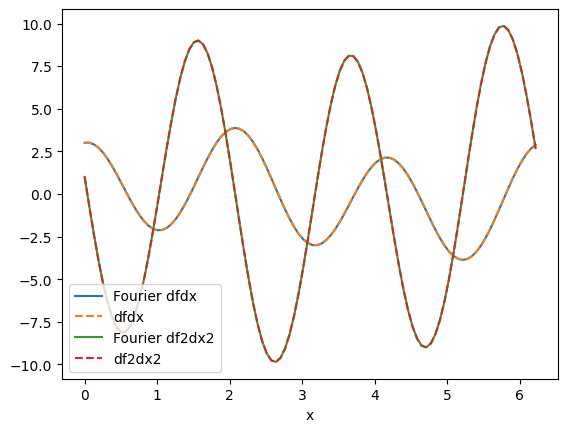

In [121]:
plt.figure()
plt.plot(x_np, dfdx[0].squeeze().cpu().numpy(), label='Fourier dfdx')
plt.plot(x_np, 3*torch.cos(3*x) + torch.sin(x), '--', label='dfdx')
plt.plot(x_np, df2dx2[0].squeeze().cpu().numpy(), label='Fourier df2dx2')
plt.plot(x_np, -9*torch.sin(3*x) + torch.cos(x), '--', label='df2dx2')
plt.xlabel('x')
plt.legend()
plt.show()

I have no clue why this is not working at the boundaries.

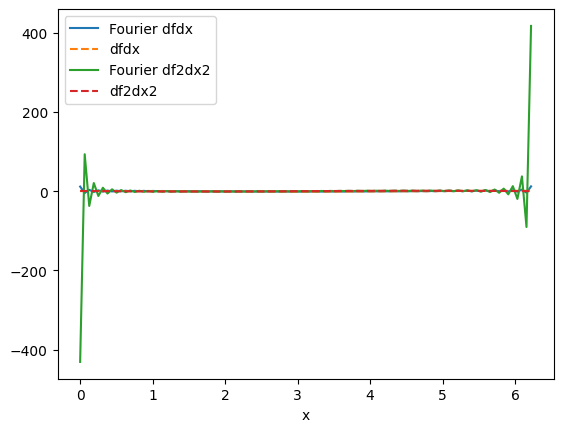

In [122]:
plt.figure()
plt.plot(x_np, dfdx[1].squeeze().cpu().numpy(), label='Fourier dfdx')
plt.plot(x_np, -0.8*torch.exp(-0.8*x)+torch.cos(x), '--', label='dfdx')
plt.plot(x_np, df2dx2[1].squeeze().cpu().numpy(), label='Fourier df2dx2')
plt.plot(x_np, 0.64*torch.exp(-0.8*x)-torch.sin(x), '--', label='df2dx2')
plt.xlabel('x')
plt.legend()
plt.show()

2D

In [94]:
L_x, L_y = 2 * torch.pi, 2 * torch.pi
nx, ny = 180, 186
x = torch.linspace(0, L_x, nx, dtype=torch.float64)
y = torch.linspace(0, L_y, ny, dtype=torch.float64)
X, Y = torch.meshgrid(x, y, indexing='ij')

# Test function: f(x,y) = sin(x) * cos(y)
f_2d = torch.sin(X) * torch.cos(Y)

In [96]:
fd2d = FourierDiff(dim=2, L=(L_x, L_y))

# Compute derivatives
df_dx = fd2d.dx(f_2d)
df_dy = fd2d.dy(f_2d)
laplacian = fd2d.laplacian(f_2d)

# Expected analytical results for f(x,y) = sin(x) * cos(y)
df_dx_expected = torch.cos(X) * torch.cos(Y)
df_dy_expected = -torch.sin(X) * torch.sin(Y)
laplacian_expected = -2 * torch.sin(X) * torch.cos(Y)

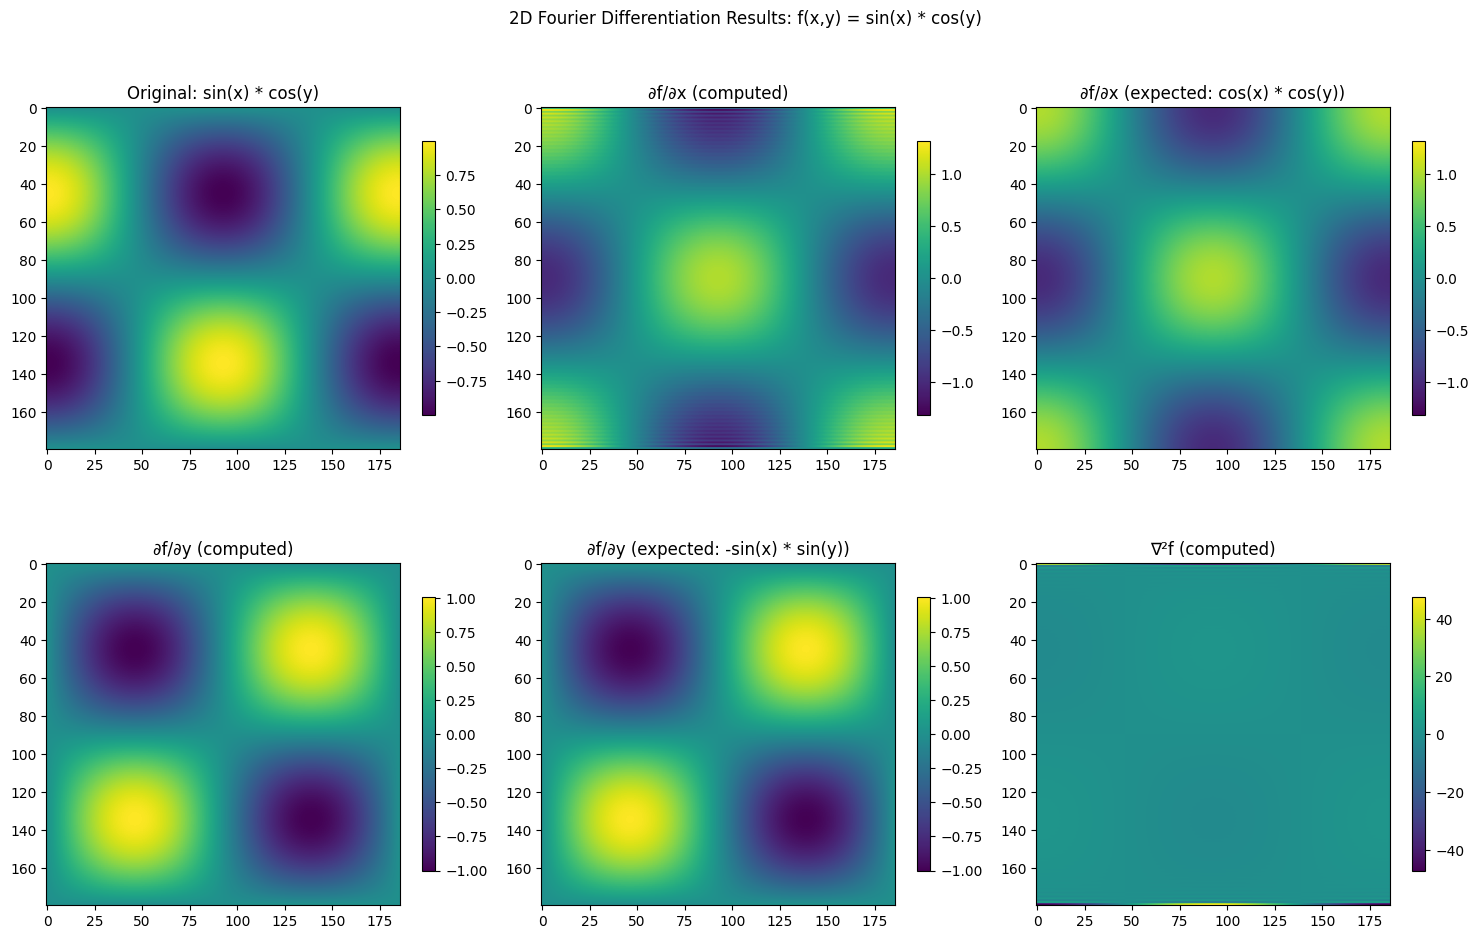

In [97]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('2D Fourier Differentiation Results: f(x,y) = sin(x) * cos(y)')

# Compute consistent colorbar limits for each derivative pair
df_dx_min = min(df_dx.min().item(), df_dx_expected.min().item())
df_dx_max = max(df_dx.max().item(), df_dx_expected.max().item())
df_dy_min = min(df_dy.min().item(), df_dy_expected.min().item())
df_dy_max = max(df_dy.max().item(), df_dy_expected.max().item())

# Original function
im0 = axes[0, 0].imshow(f_2d.cpu().numpy())
axes[0, 0].set_title('Original: sin(x) * cos(y)')
plt.colorbar(im0, ax=axes[0, 0], shrink=0.57)

# ∂f/∂x computed
im1 = axes[0, 1].imshow(df_dx.cpu().numpy(), vmin=df_dx_min, vmax=df_dx_max)
axes[0, 1].set_title('∂f/∂x (computed)')
plt.colorbar(im1, ax=axes[0, 1], shrink=0.57)

# ∂f/∂x expected
im2 = axes[0, 2].imshow(df_dx_expected.cpu().numpy(), vmin=df_dx_min, vmax=df_dx_max)
axes[0, 2].set_title('∂f/∂x (expected: cos(x) * cos(y))')
plt.colorbar(im2, ax=axes[0, 2], shrink=0.57)

# ∂f/∂y computed
im3 = axes[1, 0].imshow(df_dy.cpu().numpy(), vmin=df_dy_min, vmax=df_dy_max)
axes[1, 0].set_title('∂f/∂y (computed)')
plt.colorbar(im3, ax=axes[1, 0], shrink=0.57)

# ∂f/∂y expected
im4 = axes[1, 1].imshow(df_dy_expected.cpu().numpy(), vmin=df_dy_min, vmax=df_dy_max)
axes[1, 1].set_title('∂f/∂y (expected: -sin(x) * sin(y))')
plt.colorbar(im4, ax=axes[1, 1], shrink=0.57)

# Laplacian
im5 = axes[1, 2].imshow(laplacian.cpu().numpy())
axes[1, 2].set_title('∇²f (computed)')
plt.colorbar(im5, ax=axes[1, 2], shrink=0.57)

plt.tight_layout()
plt.show()

3D

In [98]:
L_x, L_y, L_z = 2 * torch.pi, 2 * torch.pi, 2 * torch.pi
nx, ny, nz = 176, 180, 192
x = torch.linspace(0, L_x, nx, dtype=torch.float64)
y = torch.linspace(0, L_y, ny, dtype=torch.float64)
z = torch.linspace(0, L_z, nz, dtype=torch.float64)
X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')

# Test function: f(x,y,z) = sin(x) * cos(y) * sin(z)
f_3d = torch.sin(X) * torch.cos(Y) * torch.sin(Z)

# Alternative: create tensor directly like in the test
f_3d_alt = torch.randn(nx, ny, nz, dtype=torch.float64)

In [99]:
fd3d = FourierDiff(dim=3, L=(L_x, L_y, L_z))

# Compute derivatives
df_dx_3d = fd3d.dx(f_3d)
df_dy_3d = fd3d.dy(f_3d)
df_dz_3d = fd3d.dz(f_3d)
laplacian_3d = fd3d.laplacian(f_3d)

# Expected analytical results for f(x,y,z) = sin(x) * cos(y) * sin(z)
df_dx_expected_3d = torch.cos(X) * torch.cos(Y) * torch.sin(Z)
df_dy_expected_3d = -torch.sin(X) * torch.sin(Y) * torch.sin(Z)
df_dz_expected_3d = torch.sin(X) * torch.cos(Y) * torch.cos(Z)
laplacian_expected_3d = -3 * torch.sin(X) * torch.cos(Y) * torch.sin(Z)

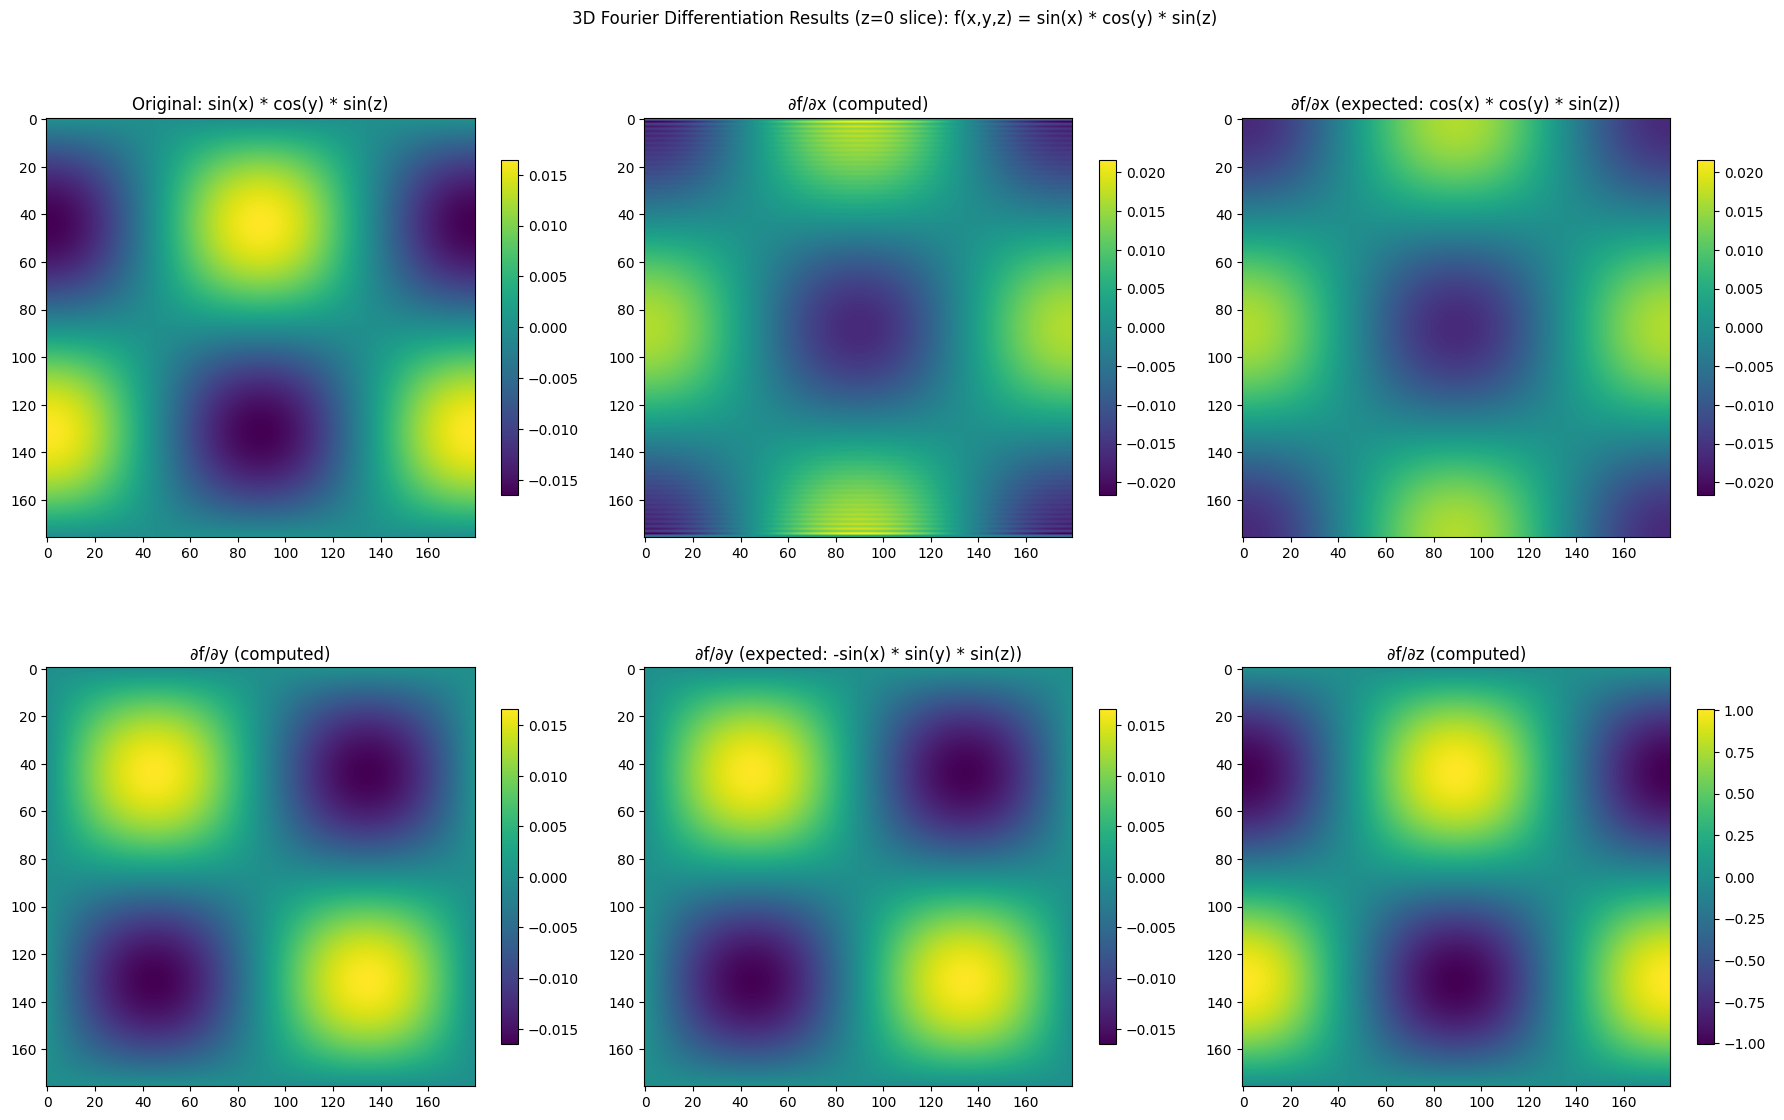

In [100]:
z_slice_idx = nz // 2
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('3D Fourier Differentiation Results (z=0 slice): f(x,y,z) = sin(x) * cos(y) * sin(z)')

# Compute consistent colorbar limits for each derivative pair at the z-slice
df_dx_3d_slice = df_dx_3d[:, :, z_slice_idx]
df_dx_expected_3d_slice = df_dx_expected_3d[:, :, z_slice_idx]
df_dy_3d_slice = df_dy_3d[:, :, z_slice_idx]
df_dy_expected_3d_slice = df_dy_expected_3d[:, :, z_slice_idx]

df_dx_3d_min = min(df_dx_3d_slice.min().item(), df_dx_expected_3d_slice.min().item())
df_dx_3d_max = max(df_dx_3d_slice.max().item(), df_dx_expected_3d_slice.max().item())
df_dy_3d_min = min(df_dy_3d_slice.min().item(), df_dy_expected_3d_slice.min().item())
df_dy_3d_max = max(df_dy_3d_slice.max().item(), df_dy_expected_3d_slice.max().item())

# Original function slice
im0 = axes[0, 0].imshow(f_3d[:, :, z_slice_idx].cpu().numpy())
axes[0, 0].set_title('Original: sin(x) * cos(y) * sin(z)')
plt.colorbar(im0, ax=axes[0, 0], shrink=0.57)

# ∂f/∂x slice
im1 = axes[0, 1].imshow(df_dx_3d_slice.cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[0, 1].set_title('∂f/∂x (computed)')
plt.colorbar(im1, ax=axes[0, 1], shrink=0.57)

# ∂f/∂x expected slice
im2 = axes[0, 2].imshow(df_dx_expected_3d_slice.cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[0, 2].set_title('∂f/∂x (expected: cos(x) * cos(y) * sin(z))')
plt.colorbar(im2, ax=axes[0, 2], shrink=0.57)

# ∂f/∂y slice
im3 = axes[1, 0].imshow(df_dy_3d_slice.cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[1, 0].set_title('∂f/∂y (computed)')
plt.colorbar(im3, ax=axes[1, 0], shrink=0.57)

# ∂f/∂y expected slice
im4 = axes[1, 1].imshow(df_dy_expected_3d_slice.cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[1, 1].set_title('∂f/∂y (expected: -sin(x) * sin(y) * sin(z))')
plt.colorbar(im4, ax=axes[1, 1], shrink=0.57)

# ∂f/∂z slice
im5 = axes[1, 2].imshow(df_dz_3d[:, :, z_slice_idx].cpu().numpy())
axes[1, 2].set_title('∂f/∂z (computed)')
plt.colorbar(im5, ax=axes[1, 2], shrink=0.57)

plt.tight_layout()
plt.show()

## Example 10: Fourier Continuation

In [103]:
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from neuralop.layers.fourier_continuation import FCLegendre

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
import torch
import torch.nn.functional as F

class FCGram:
    """
    Function extension using Gram (Legendre) polynomials for non-periodic data.
    This creates a smooth extension of f beyond its domain boundaries, making
    Fourier-based differentiation feasible for non-periodic signals.
    """

    def __init__(self, d=4, n_additional_pts=50):
        """
        Args:
            d (int): Degree of Legendre polynomial basis used for extension.
            n_additional_pts (int): Number of extra points to append at each boundary.
        """
        self.d = d
        self.n_additional_pts = n_additional_pts

    def _legendre_basis(self, x, degree):
        """Compute normalized Legendre polynomial basis up to given degree."""
        # x in [-1, 1]
        basis = [torch.ones_like(x), x]
        for n in range(2, degree + 1):
            Pn = ((2*n - 1) * x * basis[-1] - (n - 1) * basis[-2]) / n
            basis.append(Pn)
        return torch.stack(basis[:degree + 1], dim=-1)

    def _fit_boundary(self, f_boundary, side="left"):
        """
        Fit a Legendre polynomial at one side of f (1D vector).
        Returns extrapolated extension points.
        """
        n = len(f_boundary)
        x = torch.linspace(-1, 1, n, device=f_boundary.device)
        Phi = self._legendre_basis(x, self.d)
        coeffs = torch.linalg.lstsq(Phi, f_boundary.unsqueeze(-1)).solution.squeeze(-1)

        # Extrapolation region: beyond [-1,1]
        if side == "left":
            x_ext = torch.linspace(-1 - 2 * self.n_additional_pts / n, -1, self.n_additional_pts, device=f_boundary.device)
        else:
            x_ext = torch.linspace(1, 1 + 2 * self.n_additional_pts / n, self.n_additional_pts, device=f_boundary.device)

        Phi_ext = self._legendre_basis(x_ext, self.d)
        f_ext = Phi_ext @ coeffs
        return f_ext

    def __call__(self, f, dim=-1):
        """
        Extend tensor f smoothly along given dimension using Legendre polynomial extrapolation.
        f: (..., N, ...) tensor
        dim: which dimension to extend
        """
        f_shape = list(f.shape)
        N = f_shape[dim]

        # Select slices
        idx = [slice(None)] * f.dim()

        # Left boundary fit
        idx[dim] = slice(0, min(N, self.d + 1))
        f_left = f[tuple(idx)].mean(dim=tuple(i for i in range(f_left.dim()) if i != dim))
        f_ext_left = self._fit_boundary(f_left, side="left")

        # Right boundary fit
        idx[dim] = slice(-min(N, self.d + 1), None)
        f_right = f[tuple(idx)].mean(dim=tuple(i for i in range(f_right.dim()) if i != dim))
        f_ext_right = self._fit_boundary(f_right, side="right")

        # Concatenate
        extended = torch.cat([f_ext_left.unsqueeze(dim), f, f_ext_right.unsqueeze(dim)], dim=dim)
        return extended


In [147]:
import torch
import torch.nn as nn
import torch.special as sp

# Custom implementation of Legendre polynomial evaluation (since torch.special.legendre_polynomial is missing)
def legendre_polynomial(n, x):
    """
    Compute the Legendre polynomial P_n(x) using recurrence.
    Supports batched tensors.
    """
    if n == 0:
        return torch.ones_like(x)
    elif n == 1:
        return x
    else:
        Pn_1 = x  # P1(x)
        Pn_2 = torch.ones_like(x)  # P0(x)
        for k in range(2, n + 1):
            Pn = ((2 * k - 1) * x * Pn_1 - (k - 1) * Pn_2) / k
            Pn_2, Pn_1 = Pn_1, Pn
        return Pn


class FCLegendre(nn.Module):
    """
    Legendre polynomial-based function extension.
    
    Args:
        d (int): input dimension
        n_additional_pts (int): number of extra Legendre polynomial features to add
    """
    def __init__(self, d, n_additional_pts):
        super().__init__()
        self.d = d
        self.n_additional_pts = n_additional_pts
        
        # Coefficients for weighting higher-degree terms
        self.coeffs = nn.Parameter(torch.randn(n_additional_pts))

    def forward(self, f, x_new=None, dim=1):
        x = torch.linspace(-1, 1, f.shape[dim], device=f.device)
        if x_new is None:
            x_new = x
        x_new = 2 * (x_new - x_new.min()) / (x_new.max() - x_new.min()) - 1  # normalize to [-1,1]

        extensions = []
        for n in range(1, self.n_additional_pts + 1):
            Gn = gram_polynomial(n, x_new)
            ext = self.coeffs[n - 1] * Gn
            extensions.append(ext)
        extensions = torch.stack(extensions, dim=0)
        extended = f.mean() + extensions.sum(dim=0)  # baseline from f
        return extended


In [148]:
import torch
import torch.nn as nn

def gram_polynomial(n, x):
    """
    Compute the Gram polynomial G_n(x) on [-1, 1].
    Recurrence relation:
        G_0(x) = 1
        G_1(x) = 2x
        G_{n+1}(x) = ((2n+1)*x*G_n(x) - n*G_{n-1}(x)) / (n+1)
    """
    if n == 0:
        return torch.ones_like(x)
    elif n == 1:
        return 2 * x
    else:
        Gnm1 = 2 * x  # G1
        Gnm2 = torch.ones_like(x)  # G0
        for k in range(2, n + 1):
            Gn = ((2 * k - 1) * x * Gnm1 - (k - 1) * Gnm2) / k
            Gnm2, Gnm1 = Gnm1, Gn
        return Gn


class FCGram(nn.Module):
    """
    Gram polynomial-based function extension.
    
    Args:
        d (int): Input dimension.
        n_additional_pts (int): Number of polynomial basis terms to add.
    """
    def __init__(self, d, n_additional_pts):
        super().__init__()
        self.d = d
        self.n_additional_pts = n_additional_pts
        self.coeffs = nn.Parameter(torch.randn(n_additional_pts))

    def forward(self, f, x_new=None, dim=1):
        x = torch.linspace(-1, 1, f.shape[dim], device=f.device)
        if x_new is None:
            x_new = x
        x_new = 2 * (x_new - x_new.min()) / (x_new.max() - x_new.min()) - 1  # normalize to [-1,1]

        extensions = []
        for n in range(1, self.n_additional_pts + 1):
            Gn = gram_polynomial(n, x_new)
            ext = self.coeffs[n - 1] * Gn
            extensions.append(ext)
        extensions = torch.stack(extensions, dim=0)
        extended = f.mean() + extensions.sum(dim=0)  # baseline from f
        return extended


In [143]:
length_signal = 101   # length of the original 1D signal
add_pts = 50          # number of points to add
batch_size = 3        # the Fourier continuation layer can be applied to batches of signals

x = torch.linspace(0, 1, length_signal).repeat(batch_size,1)
f = torch.sin(16 * x) - torch.cos(8 * x)

In [149]:
Extension_Legendre = FCLegendre(d=2, n_additional_pts=add_pts)
f_extend_Legendre = Extension_Legendre(f)

Extension_Gram = FCGram(d=4, n_additional_pts=add_pts)
f_extend_Gram = Extension_Gram(f, dim=1)

ValueError: x and y must have same first dimension, but have shapes (151,) and (1,)

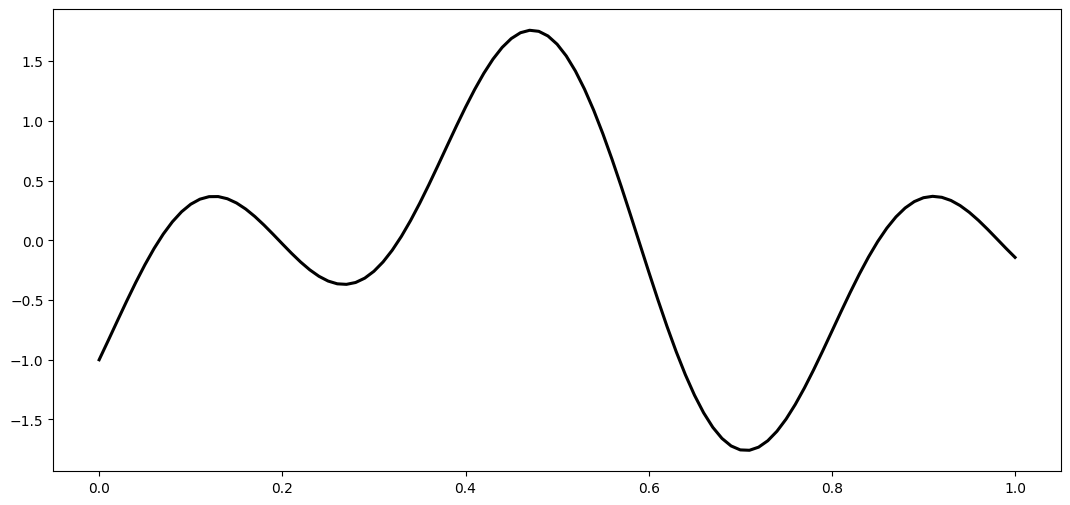

In [ ]:
# Define the extended coordinates
x_extended = torch.linspace(-0.25, 1.25, 151)

# Adjust the extended functions for visualization purposes
f_extend_Legendre_adjusted = f_extend_Legendre - 0.6
f_extend_Gram_adjusted = f_extend_Gram + 0.6

plt.figure(figsize=(13, 6))
plt.plot(x[0], f[0], 'k', label='Original Function', lw=2.2)
plt.plot(x_extended.detach().numpy(), f_extend_Gram_adjusted[0].detach().numpy(), 'b', label='FC-Gram Extension', lw=2.2)
plt.plot(x_extended.detach().numpy(), f_extend_Legendre_adjusted[0].detach().numpy(), 'g', label='FC-Legendre Extension', lw=2.2)
plt.plot([0, 0], [-2.9, 1.9], '-', color='gray', lw=1.5)
plt.plot([1, 1], [-2.9, 1.1], '-', color='gray', lw=1.5)
plt.plot([-0.25, 1.25], [f_extend_Legendre_adjusted[0,0],f_extend_Legendre_adjusted[0,0]], '--', color='g', lw=1.6)
plt.plot([-0.25, 1.25], [f_extend_Gram_adjusted[0,0],f_extend_Gram_adjusted[0,0]], '--', color='b', lw=1.6)
legend_elements = [
        Line2D([0], [0], color='k', lw=2.2, label='Original Function'),
        Line2D([0], [0], color='b', lw=2.2, label='FC-Gram Extension'),
        Line2D([0], [0], color='g', lw=2.2, label='FC-Legendre Extension')
]
legend = plt.legend(handles=legend_elements, fontsize=19)
plt.xlim([-0.28, 1.31])
plt.ylim([-3.1, 2.6])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=19)
ax.tick_params(axis='y', which='major', labelsize=19)
plt.xticks([-0.25, 0, 1, 1.25], ['-0.25', '0', '1', '1.25'])
plt.yticks([-2,2])
plt.tight_layout()
plt.show()

## Example 11: Finite Difference

In [155]:
L_x = 2 * torch.pi
nx = 256
x = torch.linspace(0, L_x, nx, dtype=torch.float64)

f_1d = torch.exp(-x) * torch.sin(x)

In [191]:
import torch

class FiniteDiff:
    def __init__(self, dim=1, h=1.0, periodic_in_x=False, **kwargs):
        """
        Finite difference operator supporting arbitrary dimensions and mixed periodic BCs.

        Args:
            dim (int): Number of spatial dimensions.
            h (float or tuple): Grid spacing (uniform or per dimension).
            periodic_in_x (bool): Periodic boundary condition for x-axis.
            kwargs: You can also specify periodic_in_y, periodic_in_z, etc.
        """
        self.dim = dim

        # --- Handle spacing (h) ---
        if isinstance(h, (int, float)):
            self.h = [float(h)] * dim
        else:
            assert len(h) == dim, "Length of h must match number of dimensions"
            self.h = list(h)

        # --- Handle periodicity flags ---
        periodic_flags = [periodic_in_x]  # Always have at least x
        axis_labels = ['x', 'y', 'z', 'w', 'u', 'v']  # for up to 6D convenience
        for i in range(1, dim):
            key = f'periodic_in_{axis_labels[i]}'
            if key in kwargs:
                periodic_flags.append(kwargs[key])
            else:
                periodic_flags.append(periodic_in_x)  # default to x’s periodicity if not specified
        self.periodic = periodic_flags

    def dx(self, f, axis=0, order=1):
        """
        Compute finite difference derivative along a given axis.

        Args:
            f (torch.Tensor): Function values on a grid.
            axis (int): Axis along which to take derivative.
            order (int): Order of derivative (1 or 2 supported).
        """
        h = self.h[axis]
        periodic = self.periodic[axis]

        if order == 1:
            if periodic:
                f_roll_fwd = torch.roll(f, shifts=-1, dims=axis)
                f_roll_bwd = torch.roll(f, shifts=1, dims=axis)
                df = (f_roll_fwd - f_roll_bwd) / (2 * h)
            else:
                df = torch.zeros_like(f)
                # central difference for interior
                sl = [slice(None)] * f.ndim
                sl[axis] = slice(1, -1)
                idx_center = tuple(sl)
                idx_fwd = list(sl); idx_fwd[axis] = slice(2, None)
                idx_bwd = list(sl); idx_bwd[axis] = slice(None, -2)
                df[idx_center] = (f[tuple(idx_fwd)] - f[tuple(idx_bwd)]) / (2 * h)
                # one-sided at edges
                sl0 = [slice(None)] * f.ndim; sl0[axis] = 0
                sl1 = [slice(None)] * f.ndim; sl1[axis] = 1
                sln1 = [slice(None)] * f.ndim; sln1[axis] = -1
                sln2 = [slice(None)] * f.ndim; sln2[axis] = -2
                df[tuple(sl0)] = (f[tuple(sl1)] - f[tuple(sl0)]) / h
                df[tuple(sln1)] = (f[tuple(sln1)] - f[tuple(sln2)]) / h
            return df

        elif order == 2:
            if periodic:
                f_plus = torch.roll(f, shifts=-1, dims=axis)
                f_minus = torch.roll(f, shifts=1, dims=axis)
                d2f = (f_plus - 2 * f + f_minus) / (h ** 2)
            else:
                d2f = torch.zeros_like(f)
                # central difference for interior
                sl = [slice(None)] * f.ndim
                sl[axis] = slice(1, -1)
                idx_center = tuple(sl)
                idx_fwd = list(sl); idx_fwd[axis] = slice(2, None)
                idx_mid = list(sl); idx_mid[axis] = slice(1, -1)
                idx_bwd = list(sl); idx_bwd[axis] = slice(None, -2)
                d2f[idx_center] = (f[tuple(idx_fwd)] - 2*f[tuple(idx_mid)] + f[tuple(idx_bwd)]) / (h ** 2)
                # one-sided for edges
                sl0 = [slice(None)] * f.ndim; sl0[axis] = 0
                sl1 = [slice(None)] * f.ndim; sl1[axis] = 1
                sl2 = [slice(None)] * f.ndim; sl2[axis] = 2
                sln = [slice(None)] * f.ndim; sln[axis] = -1
                sln1 = [slice(None)] * f.ndim; sln1[axis] = -2
                sln2 = [slice(None)] * f.ndim; sln2[axis] = -3
                d2f[tuple(sl0)] = (f[tuple(sl2)] - 2*f[tuple(sl1)] + f[tuple(sl0)]) / (h**2)
                d2f[tuple(sln)] = (f[tuple(sln)] - 2*f[tuple(sln1)] + f[tuple(sln2)]) / (h**2)
            return d2f

        else:
            raise NotImplementedError(f"Only order=1 or 2 derivatives are supported (got {order}).")
        
    def dy(self, f, axis=0, order=1):
        """
        Compute finite difference derivative along a given axis.

        Args:
            f (torch.Tensor): Function values on a grid.
            axis (int): Axis along which to take derivative.
            order (int): Order of derivative (1 or 2 supported).
        """
        return self.dx(f, axis=axis, order=order)
    
    def dz(self, f, axis=0, order=1):
        """
        Compute finite difference derivative along a given axis.

        Args:
            f (torch.Tensor): Function values on a grid.
            axis (int): Axis along which to take derivative.
            order (int): Order of derivative (1 or 2 supported).
        """
        return self.dx(f, axis=axis, order=order)

    def laplacian(self, f):
        """Compute Laplacian using second-order central differences."""
        lap = torch.zeros_like(f)
        for axis in range(self.dim):
            lap += self.dx(f, axis=axis, order=2)
        return lap
    
    def gradient(self, f):
        """Compute gradient vector using first-order central differences."""
        grads = []
        for axis in range(self.dim):
            grads.append(self.dx(f, axis=axis, order=1))
        return grads
    
    def divergence(self, vec_field):
        """Compute divergence of a vector field."""
        div = torch.zeros_like(vec_field[0])
        for axis in range(self.dim):
            div += self.dx(vec_field[axis], axis=axis, order=1)
        return div
    
    def curl(self, vec_field):
        """Compute curl of a 2D vector field."""
        if self.dim != 2:
            raise NotImplementedError("Curl is only implemented for 2D vector fields.")
        return self.dx(vec_field[1], axis=0, order=1) - self.dx(vec_field[0], axis=1, order=1)

In [165]:
h = L_x / nx

# Compute derivatives
fd1d = FiniteDiff(dim=1, h=h, periodic_in_x=False)
df_dx = fd1d.dx(f_1d)
d2f_dx2 = fd1d.dx(f_1d, order=2)

# Expected analytical results for f(x) = exp(-x) * sin(x)
df_dx_expected = torch.exp(-x) * (torch.cos(x) - torch.sin(x))  # ∂f/∂x
d2f_dx2_expected = torch.exp(-x) * (-2*torch.cos(x))  # ∂²f/∂x²

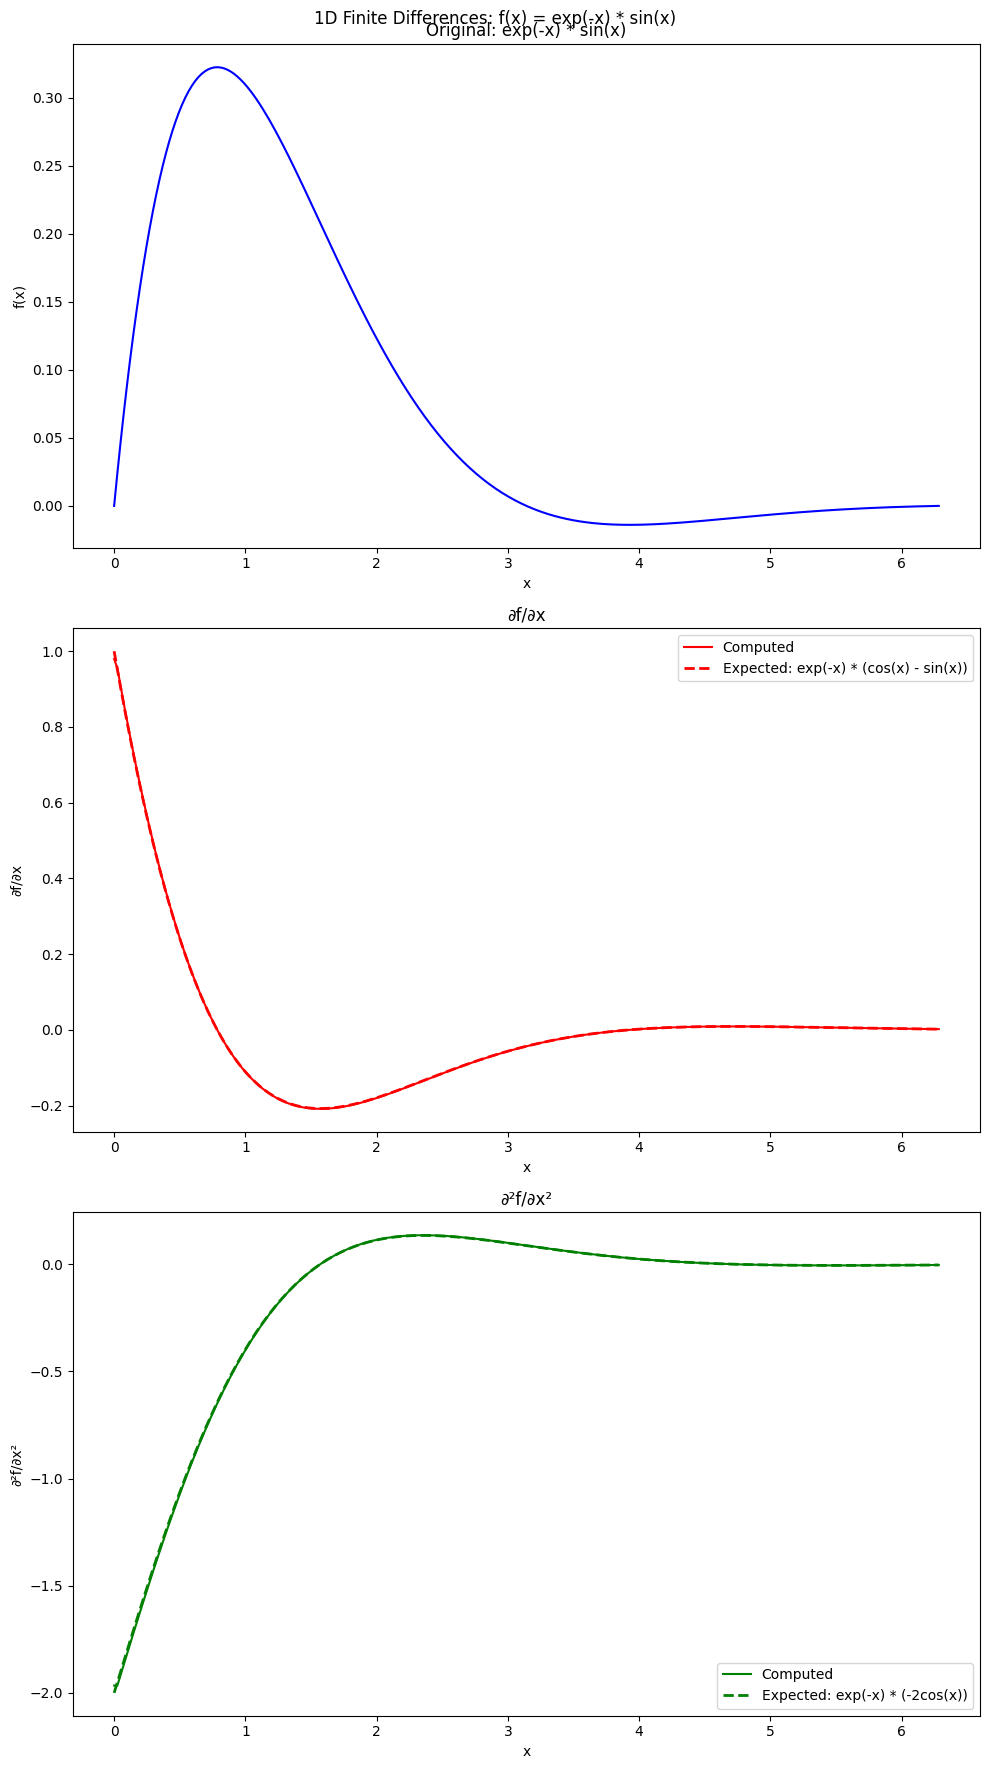

In [166]:
fig, axes = plt.subplots(3, 1, figsize=(10, 18))
fig.suptitle('1D Finite Differences: f(x) = exp(-x) * sin(x)')

# Original function
axes[0].plot(x.cpu().numpy(), f_1d.cpu().numpy(), 'b-', linewidth=1.5)
axes[0].set_title('Original: exp(-x) * sin(x)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')

# First derivative
axes[1].plot(x.cpu().numpy(), df_dx.cpu().numpy(), 'r-', linewidth=1.5, label='Computed')
axes[1].plot(x.cpu().numpy(), df_dx_expected.cpu().numpy(), 'r--', linewidth=2, label='Expected: exp(-x) * (cos(x) - sin(x))')
axes[1].set_title('∂f/∂x')
axes[1].set_xlabel('x')
axes[1].set_ylabel('∂f/∂x')
axes[1].legend()

# Second derivative
axes[2].plot(x.cpu().numpy(), d2f_dx2.cpu().numpy(), 'g-', linewidth=1.5, label='Computed')
axes[2].plot(x.cpu().numpy(), d2f_dx2_expected.cpu().numpy(), 'g--', linewidth=2, label='Expected: exp(-x) * (-2cos(x))')
axes[2].set_title('∂²f/∂x²')
axes[2].set_xlabel('x')
axes[2].set_ylabel('∂²f/∂x²')
axes[2].legend()

plt.tight_layout()
plt.show()

Here we consider f(x,y) = exp(-x) * sin(y), which is non-periodic on [0, 2π] × [0, 2π]

In [167]:
L_x, L_y = 2 * torch.pi, 2 * torch.pi
nx, ny = 256, 256
x = torch.linspace(0, L_x, nx, dtype=torch.float64)
y = torch.linspace(0, L_y, ny, dtype=torch.float64)
X, Y = torch.meshgrid(x, y, indexing='ij')

# Test function: f(x,y) = exp(-x) * sin(y)
f_2d = torch.exp(-X) * torch.sin(Y)

In [184]:
fd2d = FiniteDiff(dim=2, h=(L_x/nx, L_y/ny), periodic_in_x=False, periodic_in_y=False)

# Compute derivatives
df_dx = fd2d.dx(f_2d)
df_dy = fd2d.dy(f_2d)
d2f_dx2 = fd2d.dx(f_2d, order=2)
d2f_dy2 = fd2d.dy(f_2d, order=2)
laplacian = fd2d.laplacian(f_2d)

# Expected analytical results for f(x,y) = exp(-x) * sin(y)
df_dx_expected = -torch.exp(-X) * torch.sin(Y)  # ∂f/∂x
df_dy_expected = torch.exp(-X) * torch.cos(Y)   # ∂f/∂y
d2f_dx2_expected = torch.exp(-X) * torch.sin(Y)  # ∂²f/∂x²
d2f_dy2_expected = -torch.exp(-X) * torch.sin(Y)  # ∂²f/∂y²
laplacian_expected = torch.zeros_like(X)  # ∇²f

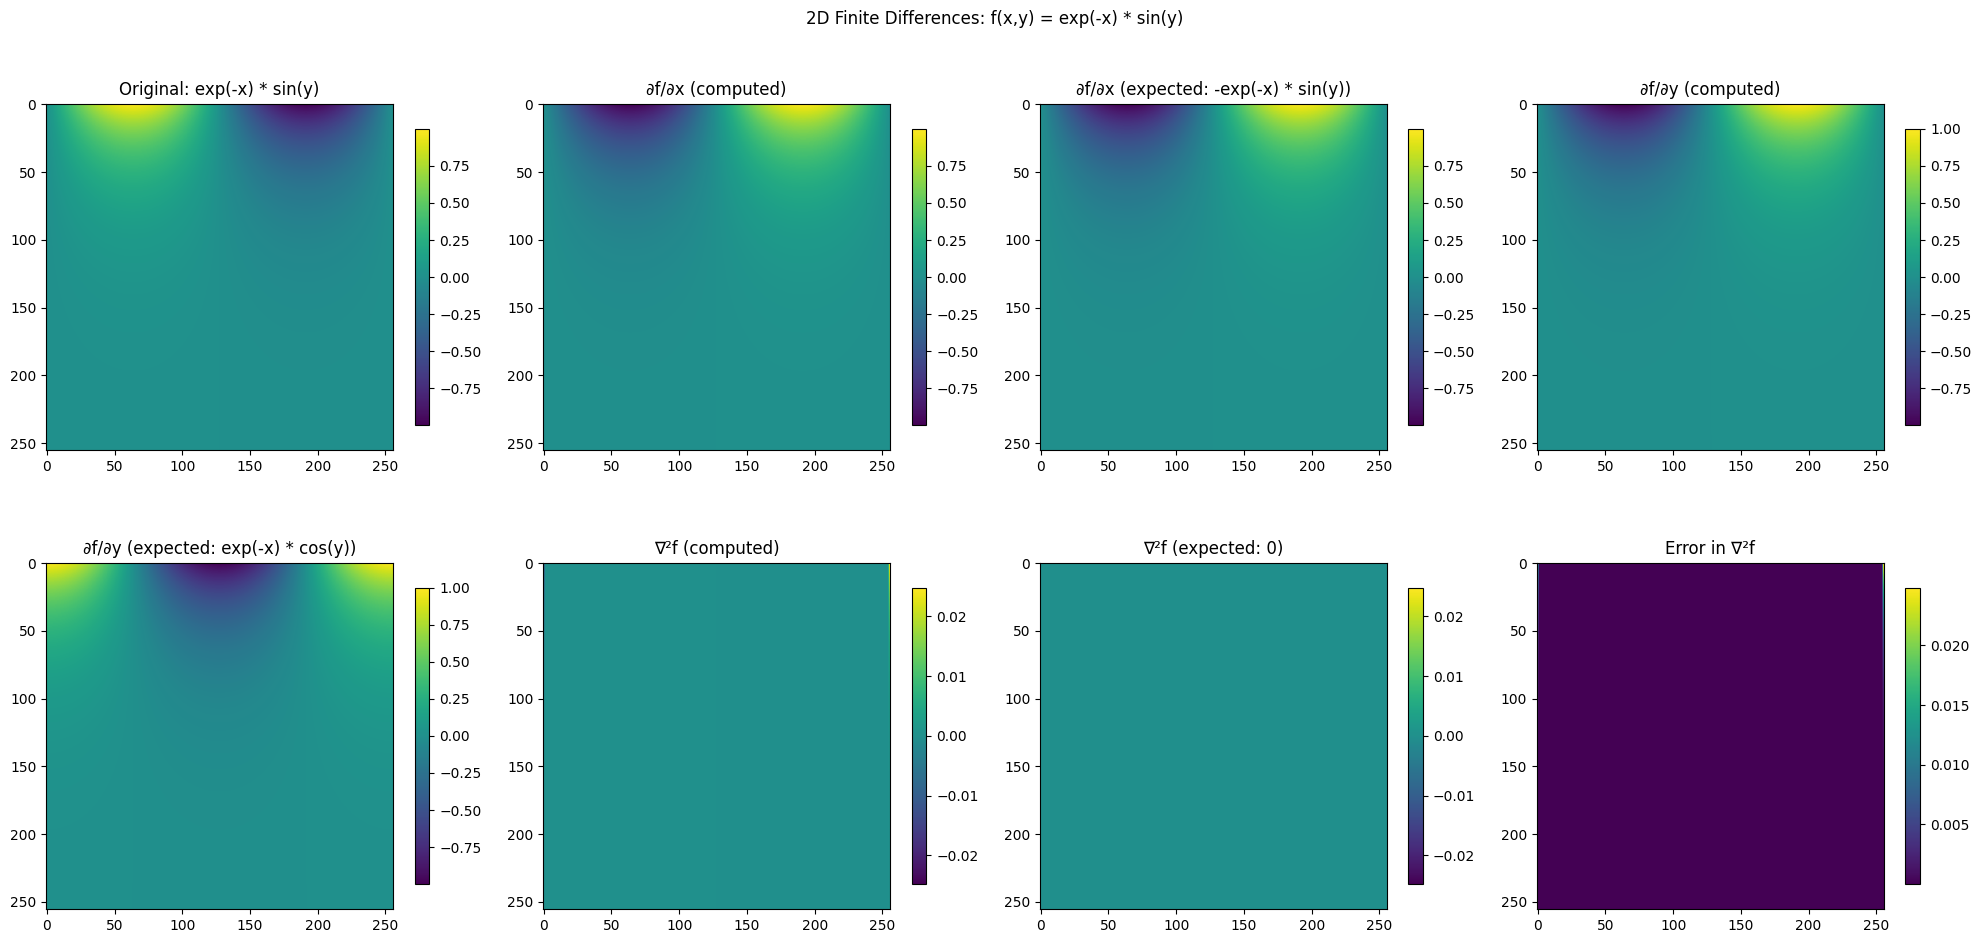

In [171]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('2D Finite Differences: f(x,y) = exp(-x) * sin(y)')

# Compute consistent colorbar limits for each derivative pair
df_dx_min = min(df_dx.min().item(), df_dx_expected.min().item())
df_dx_max = max(df_dx.max().item(), df_dx_expected.max().item())
df_dy_min = min(df_dy.min().item(), df_dy_expected.min().item())
df_dy_max = max(df_dy.max().item(), df_dy_expected.max().item())

# Compute consistent colorbar limits for second derivatives
d2f_dx2_min = min(d2f_dx2.min().item(), d2f_dx2_expected.min().item())
d2f_dx2_max = max(d2f_dx2.max().item(), d2f_dx2_expected.max().item())
d2f_dy2_min = min(d2f_dy2.min().item(), d2f_dy2_expected.min().item())
d2f_dy2_max = max(d2f_dy2.max().item(), d2f_dy2_expected.max().item())

# Compute consistent colorbar limits for laplacian
laplacian_min = min(laplacian.min().item(), laplacian_expected.min().item())
laplacian_max = max(laplacian.max().item(), laplacian_expected.max().item())

# Original function
im0 = axes[0, 0].imshow(f_2d.cpu().numpy())
axes[0, 0].set_title('Original: exp(-x) * sin(y)')
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

# ∂f/∂x computed
im1 = axes[0, 1].imshow(df_dx.cpu().numpy(), vmin=df_dx_min, vmax=df_dx_max)
axes[0, 1].set_title('∂f/∂x (computed)')
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# ∂f/∂x expected
im2 = axes[0, 2].imshow(df_dx_expected.cpu().numpy(), vmin=df_dx_min, vmax=df_dx_max)
axes[0, 2].set_title('∂f/∂x (expected: -exp(-x) * sin(y))')
plt.colorbar(im2, ax=axes[0, 2], shrink=0.62)

# ∂f/∂y computed
im3 = axes[0, 3].imshow(df_dy.cpu().numpy(), vmin=df_dy_min, vmax=df_dy_max)
axes[0, 3].set_title('∂f/∂y (computed)')
plt.colorbar(im3, ax=axes[0, 3], shrink=0.62)

# ∂f/∂y expected
im4 = axes[1, 0].imshow(df_dy_expected.cpu().numpy(), vmin=df_dy_min, vmax=df_dy_max)
axes[1, 0].set_title('∂f/∂y (expected: exp(-x) * cos(y))')
plt.colorbar(im4, ax=axes[1, 0], shrink=0.62)

# Laplacian computed
im5 = axes[1, 1].imshow(laplacian.cpu().numpy(), vmin=laplacian_min, vmax=laplacian_max)
axes[1, 1].set_title('∇²f (computed)')
plt.colorbar(im5, ax=axes[1, 1], shrink=0.62)

# Laplacian expected
im6 = axes[1, 2].imshow(laplacian_expected.cpu().numpy(), vmin=laplacian_min, vmax=laplacian_max)
axes[1, 2].set_title('∇²f (expected: 0)')
plt.colorbar(im6, ax=axes[1, 2], shrink=0.62)

# Error in laplacian
error = torch.abs(laplacian - laplacian_expected)
im7 = axes[1, 3].imshow(error.cpu().numpy())
axes[1, 3].set_title('Error in ∇²f')
plt.colorbar(im7, ax=axes[1, 3], shrink=0.62)

plt.tight_layout()
plt.show()


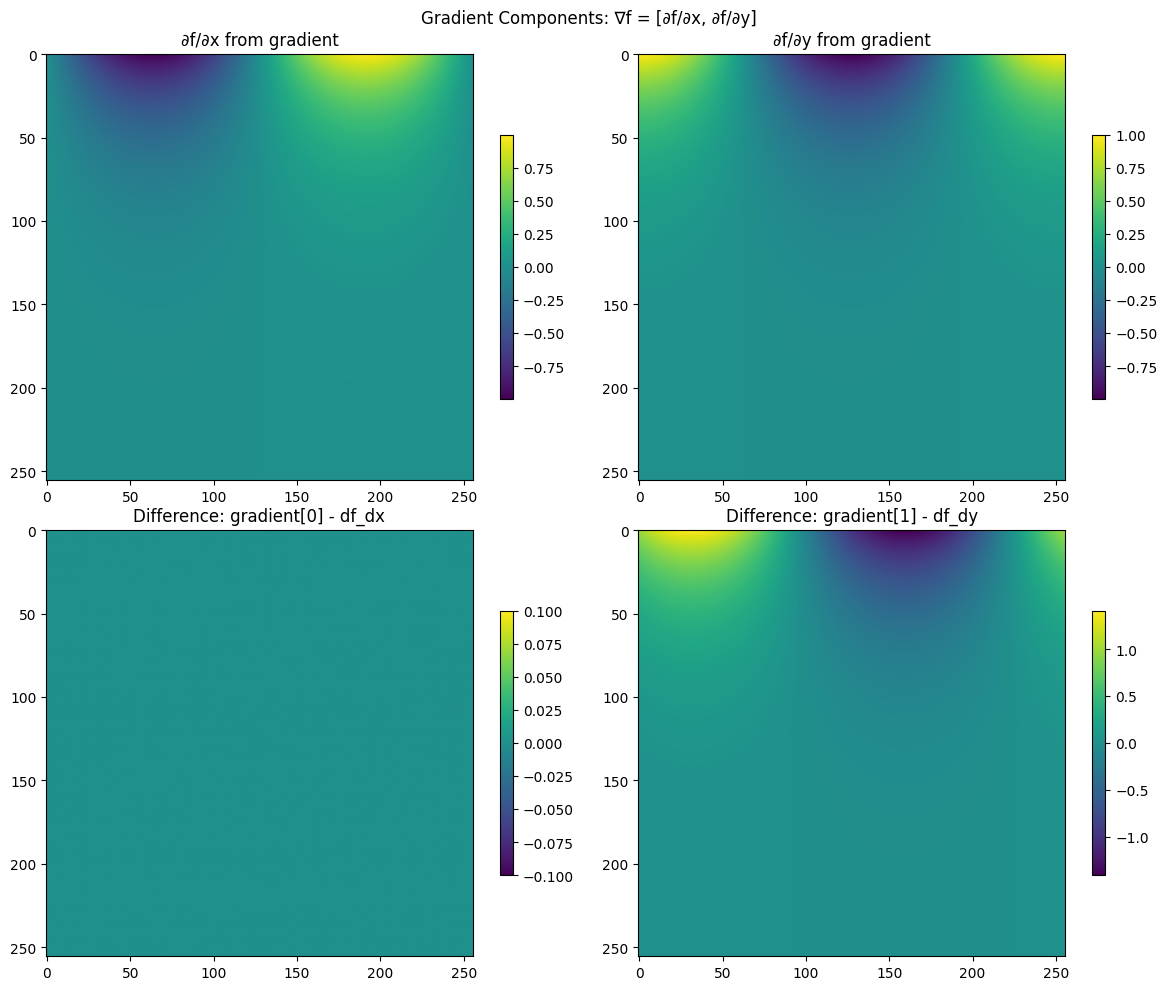

In [180]:
gradient = fd2d.gradient(f_2d)  # Returns [df_dx, df_dy]

# Plot gradient components
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Gradient Components: ∇f = [∂f/∂x, ∂f/∂y]')

# ∂f/∂x from gradient
im0 = axes[0, 0].imshow(gradient[0].cpu().numpy(), vmin=df_dx_min, vmax=df_dx_max)
axes[0, 0].set_title('∂f/∂x from gradient')
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

# ∂f/∂y from gradient
im1 = axes[0, 1].imshow(gradient[1].cpu().numpy(), vmin=df_dy_min, vmax=df_dy_max)
axes[0, 1].set_title('∂f/∂y from gradient')
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# Compare with direct computation
im2 = axes[1, 0].imshow((gradient[0] - df_dx).cpu().numpy())
axes[1, 0].set_title('Difference: gradient[0] - df_dx')
plt.colorbar(im2, ax=axes[1, 0], shrink=0.62)

im3 = axes[1, 1].imshow((gradient[1] - df_dy).cpu().numpy())
axes[1, 1].set_title('Difference: gradient[1] - df_dy')
plt.colorbar(im3, ax=axes[1, 1], shrink=0.62)

plt.tight_layout()
plt.show()


In [185]:
u1 = torch.exp(-X)
u2 = torch.sin(Y)
u_vector = torch.stack([u1, u2], dim=0)

# Compute divergence and curl
divergence = fd2d.divergence(u_vector)
curl = fd2d.curl(u_vector)

# Expected analytical results
# ∇·u = ∂u₁/∂x + ∂u₂/∂y = -exp(-x) + cos(y)
divergence_expected = -torch.exp(-X) + torch.cos(Y)
# ∇×u = ∂u₂/∂x - ∂u₁/∂y = 0 - 0 = 0 (since u₁ doesn't depend on y, u₂ doesn't depend on x)
curl_expected = torch.zeros_like(X)

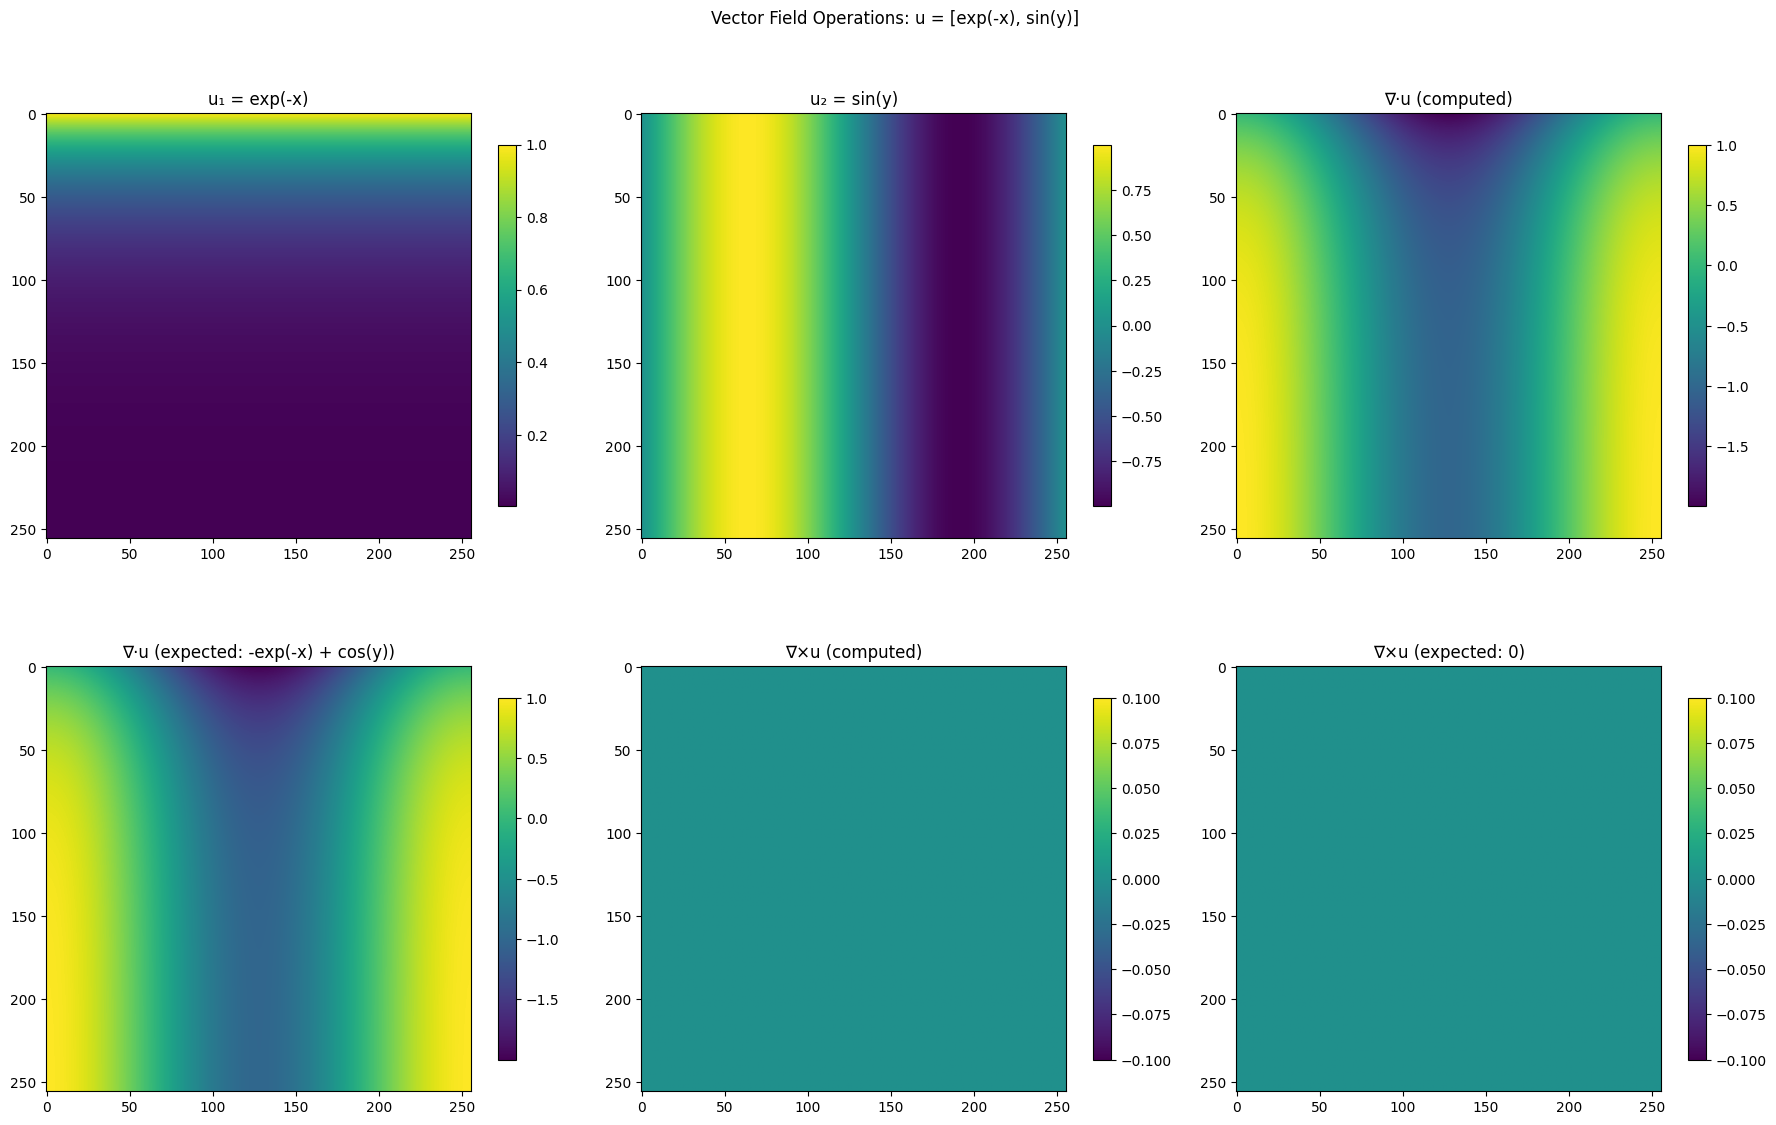

In [186]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Vector Field Operations: u = [exp(-x), sin(y)]')

# Compute consistent colorbar limits for vector field components
u1_min = min(u1.min().item(), u1.max().item())
u1_max = max(u1.min().item(), u1.max().item())
u2_min = min(u2.min().item(), u2.max().item())
u2_max = max(u2.min().item(), u2.max().item())

# Compute consistent colorbar limits for divergence
div_min = min(divergence.min().item(), divergence_expected.min().item())
div_max = max(divergence.max().item(), divergence_expected.max().item())

# Compute consistent colorbar limits for curl
curl_min = min(curl.min().item(), curl_expected.min().item())
curl_max = max(curl.max().item(), curl_expected.max().item())

# Vector field components
im0 = axes[0, 0].imshow(u1.cpu().numpy(), vmin=u1_min, vmax=u1_max)
axes[0, 0].set_title('u₁ = exp(-x)')
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

im1 = axes[0, 1].imshow(u2.cpu().numpy(), vmin=u2_min, vmax=u2_max)
axes[0, 1].set_title('u₂ = sin(y)')
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# Divergence
im2 = axes[0, 2].imshow(divergence.cpu().numpy(), vmin=div_min, vmax=div_max)
axes[0, 2].set_title('∇·u (computed)')
plt.colorbar(im2, ax=axes[0, 2], shrink=0.62)

# Divergence expected
im3 = axes[1, 0].imshow(divergence_expected.cpu().numpy(), vmin=div_min, vmax=div_max)
axes[1, 0].set_title('∇·u (expected: -exp(-x) + cos(y))')
plt.colorbar(im3, ax=axes[1, 0], shrink=0.62)

# Curl
im4 = axes[1, 1].imshow(curl.cpu().numpy(), vmin=curl_min, vmax=curl_max)
axes[1, 1].set_title('∇×u (computed)')
plt.colorbar(im4, ax=axes[1, 1], shrink=0.62)

# Curl expected
im5 = axes[1, 2].imshow(curl_expected.cpu().numpy(), vmin=curl_min, vmax=curl_max)
axes[1, 2].set_title('∇×u (expected: 0)')
plt.colorbar(im5, ax=axes[1, 2], shrink=0.62)

plt.tight_layout()
plt.show()

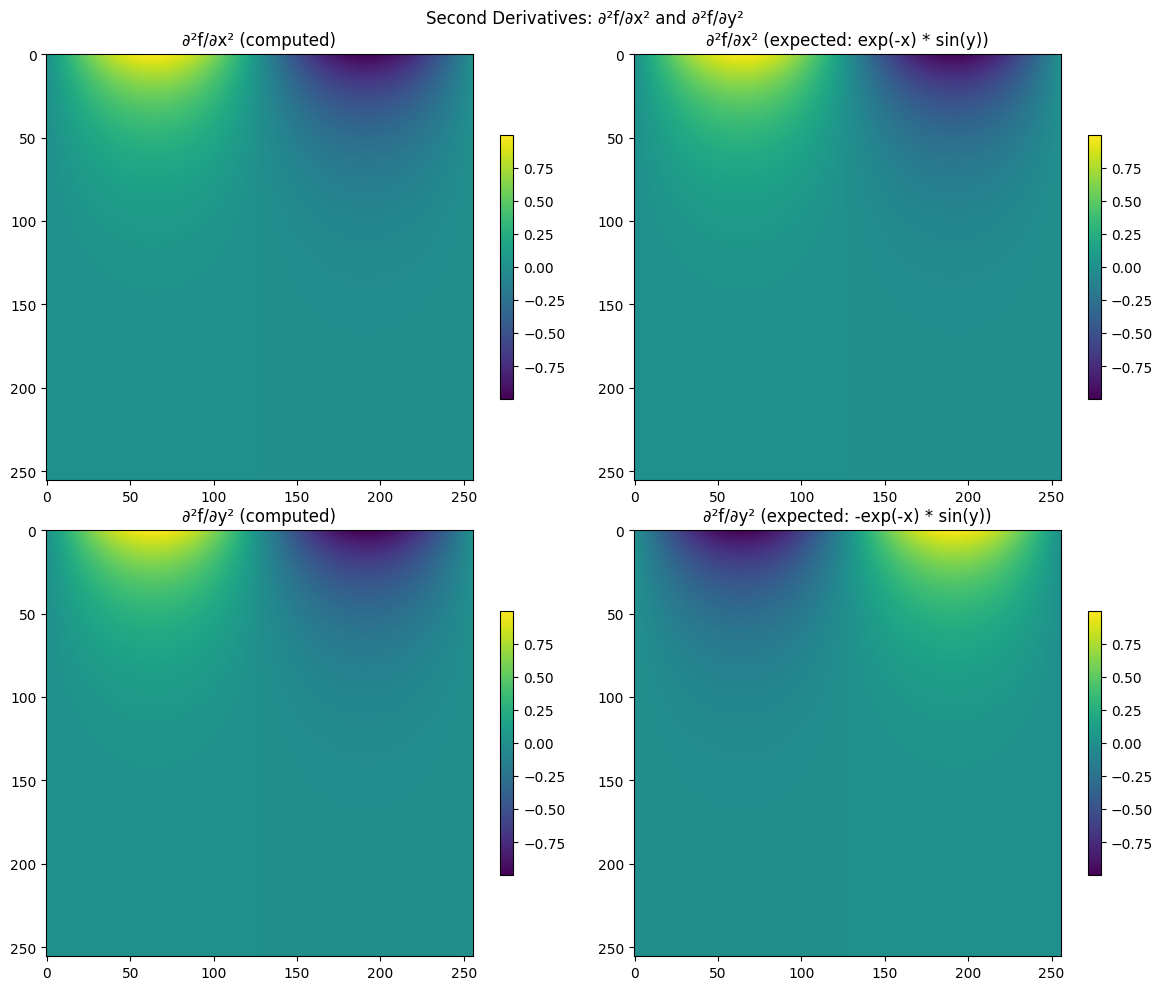

In [187]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Second Derivatives: ∂²f/∂x² and ∂²f/∂y²')

# ∂²f/∂x² computed
im0 = axes[0, 0].imshow(d2f_dx2.cpu().numpy(), vmin=d2f_dx2_min, vmax=d2f_dx2_max)
axes[0, 0].set_title('∂²f/∂x² (computed)')
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

# ∂²f/∂x² expected
im1 = axes[0, 1].imshow(d2f_dx2_expected.cpu().numpy(), vmin=d2f_dx2_min, vmax=d2f_dx2_max)
axes[0, 1].set_title('∂²f/∂x² (expected: exp(-x) * sin(y))')
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# ∂²f/∂y² computed
im2 = axes[1, 0].imshow(d2f_dy2.cpu().numpy(), vmin=d2f_dy2_min, vmax=d2f_dy2_max)
axes[1, 0].set_title('∂²f/∂y² (computed)')
plt.colorbar(im2, ax=axes[1, 0], shrink=0.62)

# ∂²f/∂y² expected
im3 = axes[1, 1].imshow(d2f_dy2_expected.cpu().numpy(), vmin=d2f_dy2_min, vmax=d2f_dy2_max)
axes[1, 1].set_title('∂²f/∂y² (expected: -exp(-x) * sin(y))')
plt.colorbar(im3, ax=axes[1, 1], shrink=0.62)

plt.tight_layout()
plt.show()

In [188]:
L_x, L_y, L_z = 2 * torch.pi, 2 * torch.pi, 2 * torch.pi
nx, ny, nz = 80, 84, 76
x = torch.linspace(0, L_x, nx, dtype=torch.float64)
y = torch.linspace(0, L_y, ny, dtype=torch.float64)
z = torch.linspace(0, L_z, nz, dtype=torch.float64)
X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')

# Test function: f(x,y,z) = exp(-x) * sin(y) * cos(z)
f_3d = torch.exp(-X) * torch.sin(Y) * torch.cos(Z)

In [192]:
fd3d = FiniteDiff(dim=3, h=(L_x/nx, L_y/ny, L_z/nz), periodic_in_x=False, periodic_in_y=True, periodic_in_z=True)

# Compute derivatives
df_dx = fd3d.dx(f_3d)
df_dy = fd3d.dy(f_3d)
df_dz = fd3d.dz(f_3d)
d2f_dx2 = fd3d.dx(f_3d, order=2)
d2f_dy2 = fd3d.dy(f_3d, order=2)
d2f_dz2 = fd3d.dz(f_3d, order=2)
laplacian_3d = fd3d.laplacian(f_3d)

# Expected analytical results for f(x,y,z) = exp(-x) * sin(y) * cos(z)
df_dx_expected = -torch.exp(-X) * torch.sin(Y) * torch.cos(Z)  # ∂f/∂x
df_dy_expected = torch.exp(-X) * torch.cos(Y) * torch.cos(Z)   # ∂f/∂y
df_dz_expected = -torch.exp(-X) * torch.sin(Y) * torch.sin(Z)  # ∂f/∂z

d2f_dx2_expected = torch.exp(-X) * torch.sin(Y) * torch.cos(Z)   # ∂²f/∂x²
d2f_dy2_expected = -torch.exp(-X) * torch.sin(Y) * torch.cos(Z)  # ∂²f/∂y²
d2f_dz2_expected = -torch.exp(-X) * torch.sin(Y) * torch.cos(Z)  # ∂²f/∂z²

# Laplacian: ∇²f = ∂²f/∂x² + ∂²f/∂y² + ∂²f/∂z²
laplacian_3d_expected = -torch.exp(-X) * torch.sin(Y) * torch.cos(Z)

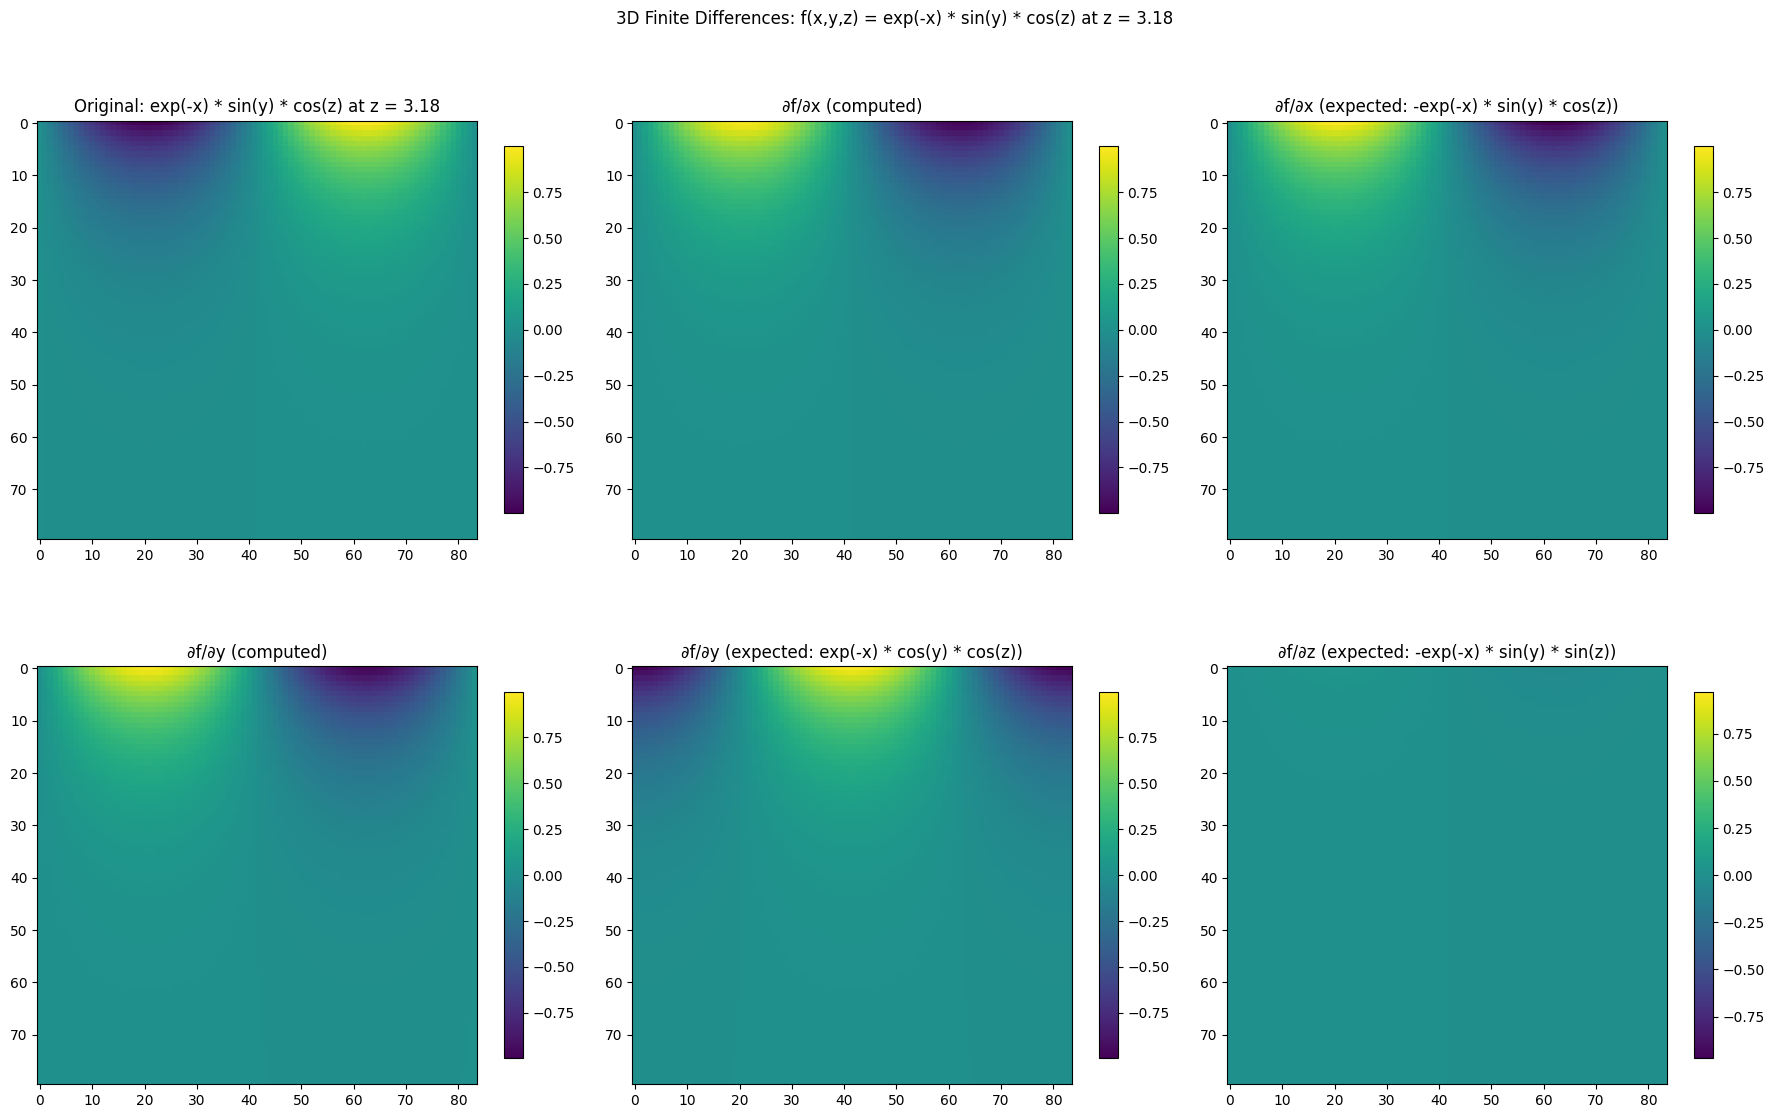

In [193]:
z_slice_idx = nz // 2  # Middle z-slice
z_slice_val = z[z_slice_idx].item()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'3D Finite Differences: f(x,y,z) = exp(-x) * sin(y) * cos(z) at z = {z_slice_val:.2f}')

# Compute consistent colorbar limits for each derivative pair at the z-slice
df_dx_3d_slice = df_dx[:, :, z_slice_idx]
df_dx_expected_3d_slice = df_dx_expected[:, :, z_slice_idx]
df_dy_3d_slice = df_dy[:, :, z_slice_idx]
df_dy_expected_3d_slice = df_dy_expected[:, :, z_slice_idx]
df_dz_3d_slice = df_dz[:, :, z_slice_idx]
df_dz_expected_3d_slice = df_dz_expected[:, :, z_slice_idx]

df_dx_3d_min = min(df_dx_3d_slice.min().item(), df_dx_expected_3d_slice.min().item())
df_dx_3d_max = max(df_dx_3d_slice.max().item(), df_dx_expected_3d_slice.max().item())
df_dy_3d_min = min(df_dy_3d_slice.min().item(), df_dy_expected_3d_slice.min().item())
df_dy_3d_max = max(df_dy_3d_slice.max().item(), df_dy_expected_3d_slice.max().item())
df_dz_3d_min = min(df_dz_3d_slice.min().item(), df_dz_expected_3d_slice.min().item())
df_dz_3d_max = max(df_dz_3d_slice.max().item(), df_dz_expected_3d_slice.max().item())

# Original function at z-slice
im0 = axes[0, 0].imshow(f_3d[:, :, z_slice_idx].cpu().numpy())
axes[0, 0].set_title(f'Original: exp(-x) * sin(y) * cos(z) at z = {z_slice_val:.2f}')
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

# ∂f/∂x computed
im1 = axes[0, 1].imshow(df_dx_3d_slice.cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[0, 1].set_title('∂f/∂x (computed)')
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# ∂f/∂x expected
im2 = axes[0, 2].imshow(df_dx_expected_3d_slice.cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[0, 2].set_title('∂f/∂x (expected: -exp(-x) * sin(y) * cos(z))')
plt.colorbar(im2, ax=axes[0, 2], shrink=0.62)

# ∂f/∂y computed
im3 = axes[1, 0].imshow(df_dy_3d_slice.cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[1, 0].set_title('∂f/∂y (computed)')
plt.colorbar(im3, ax=axes[1, 0], shrink=0.62)

# ∂f/∂y expected
im4 = axes[1, 1].imshow(df_dy_expected_3d_slice.cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[1, 1].set_title('∂f/∂y (expected: exp(-x) * cos(y) * cos(z))')
plt.colorbar(im4, ax=axes[1, 1], shrink=0.62)

# ∂f/∂z expected
im5 = axes[1, 2].imshow(df_dz_expected_3d_slice.cpu().numpy(), vmin=df_dz_3d_min, vmax=df_dz_3d_max)
axes[1, 2].set_title('∂f/∂z (expected: -exp(-x) * sin(y) * sin(z))')
plt.colorbar(im5, ax=axes[1, 2], shrink=0.62)

plt.tight_layout()
plt.show()

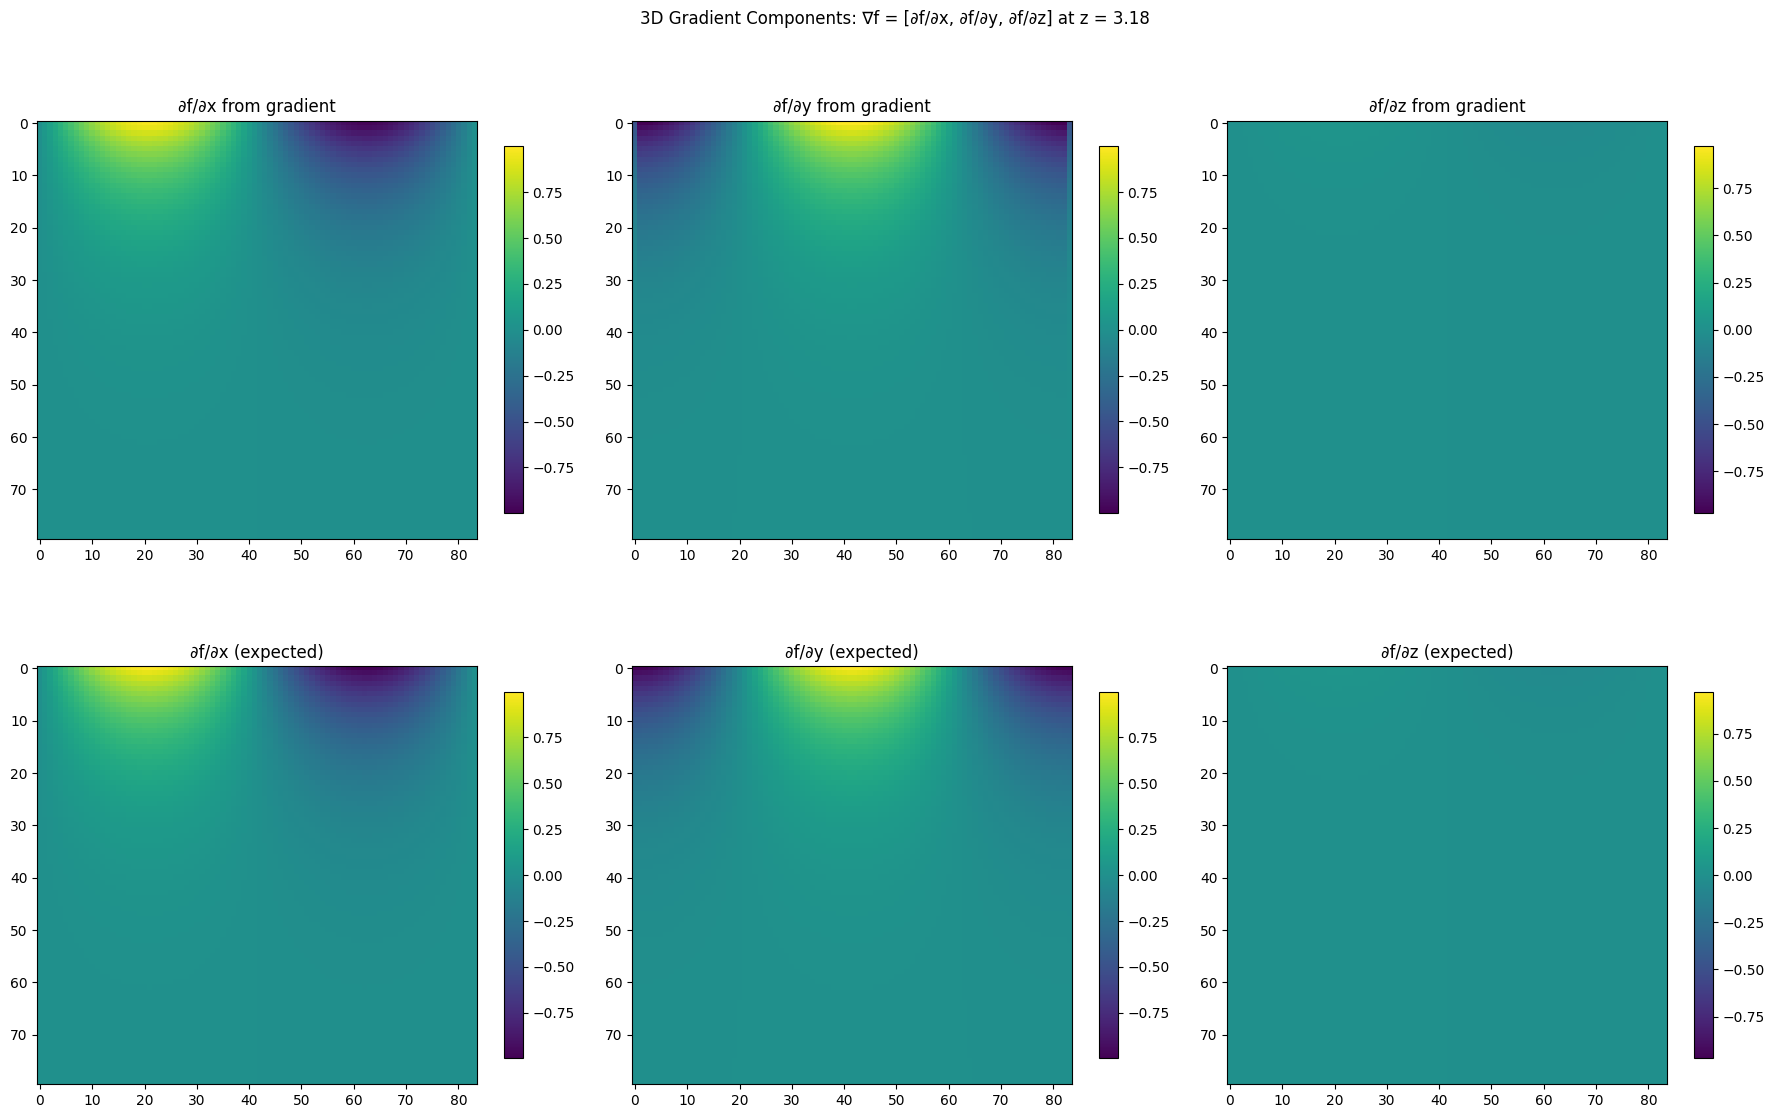

In [194]:
gradient_3d = fd3d.gradient(f_3d)  # Returns [df_dx, df_dy, df_dz]

# Plot gradient components at z-slice
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'3D Gradient Components: ∇f = [∂f/∂x, ∂f/∂y, ∂f/∂z] at z = {z_slice_val:.2f}')

# ∂f/∂x from gradient
im0 = axes[0, 0].imshow(gradient_3d[0][:, :, z_slice_idx].cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[0, 0].set_title('∂f/∂x from gradient')
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

# ∂f/∂y from gradient
im1 = axes[0, 1].imshow(gradient_3d[1][:, :, z_slice_idx].cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[0, 1].set_title('∂f/∂y from gradient')
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# ∂f/∂z from gradient
im2 = axes[0, 2].imshow(gradient_3d[2][:, :, z_slice_idx].cpu().numpy(), vmin=df_dz_3d_min, vmax=df_dz_3d_max)
axes[0, 2].set_title('∂f/∂z from gradient')
plt.colorbar(im2, ax=axes[0, 2], shrink=0.62)

# Reference gradient components (expected values)
im3 = axes[1, 0].imshow(df_dx_expected_3d_slice.cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[1, 0].set_title('∂f/∂x (expected)')
plt.colorbar(im3, ax=axes[1, 0], shrink=0.62)

im4 = axes[1, 1].imshow(df_dy_expected_3d_slice.cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[1, 1].set_title('∂f/∂y (expected)')
plt.colorbar(im4, ax=axes[1, 1], shrink=0.62)

im5 = axes[1, 2].imshow(df_dz_expected_3d_slice.cpu().numpy(), vmin=df_dz_3d_min, vmax=df_dz_3d_max)
axes[1, 2].set_title('∂f/∂z (expected)')
plt.colorbar(im5, ax=axes[1, 2], shrink=0.62)

plt.tight_layout()
plt.show()

In [195]:
u1_3d = torch.exp(-X)
u2_3d = torch.sin(Y)
u3_3d = torch.cos(Z)
u_vector_3d = torch.stack([u1_3d, u2_3d, u3_3d], dim=0)

# Compute divergence
divergence_3d = fd3d.divergence(u_vector_3d)

# Expected analytical results
# ∇·u = ∂u₁/∂x + ∂u₂/∂y + ∂u₃/∂z
divergence_3d_expected = -torch.exp(-X) + torch.cos(Y) - torch.sin(Z)

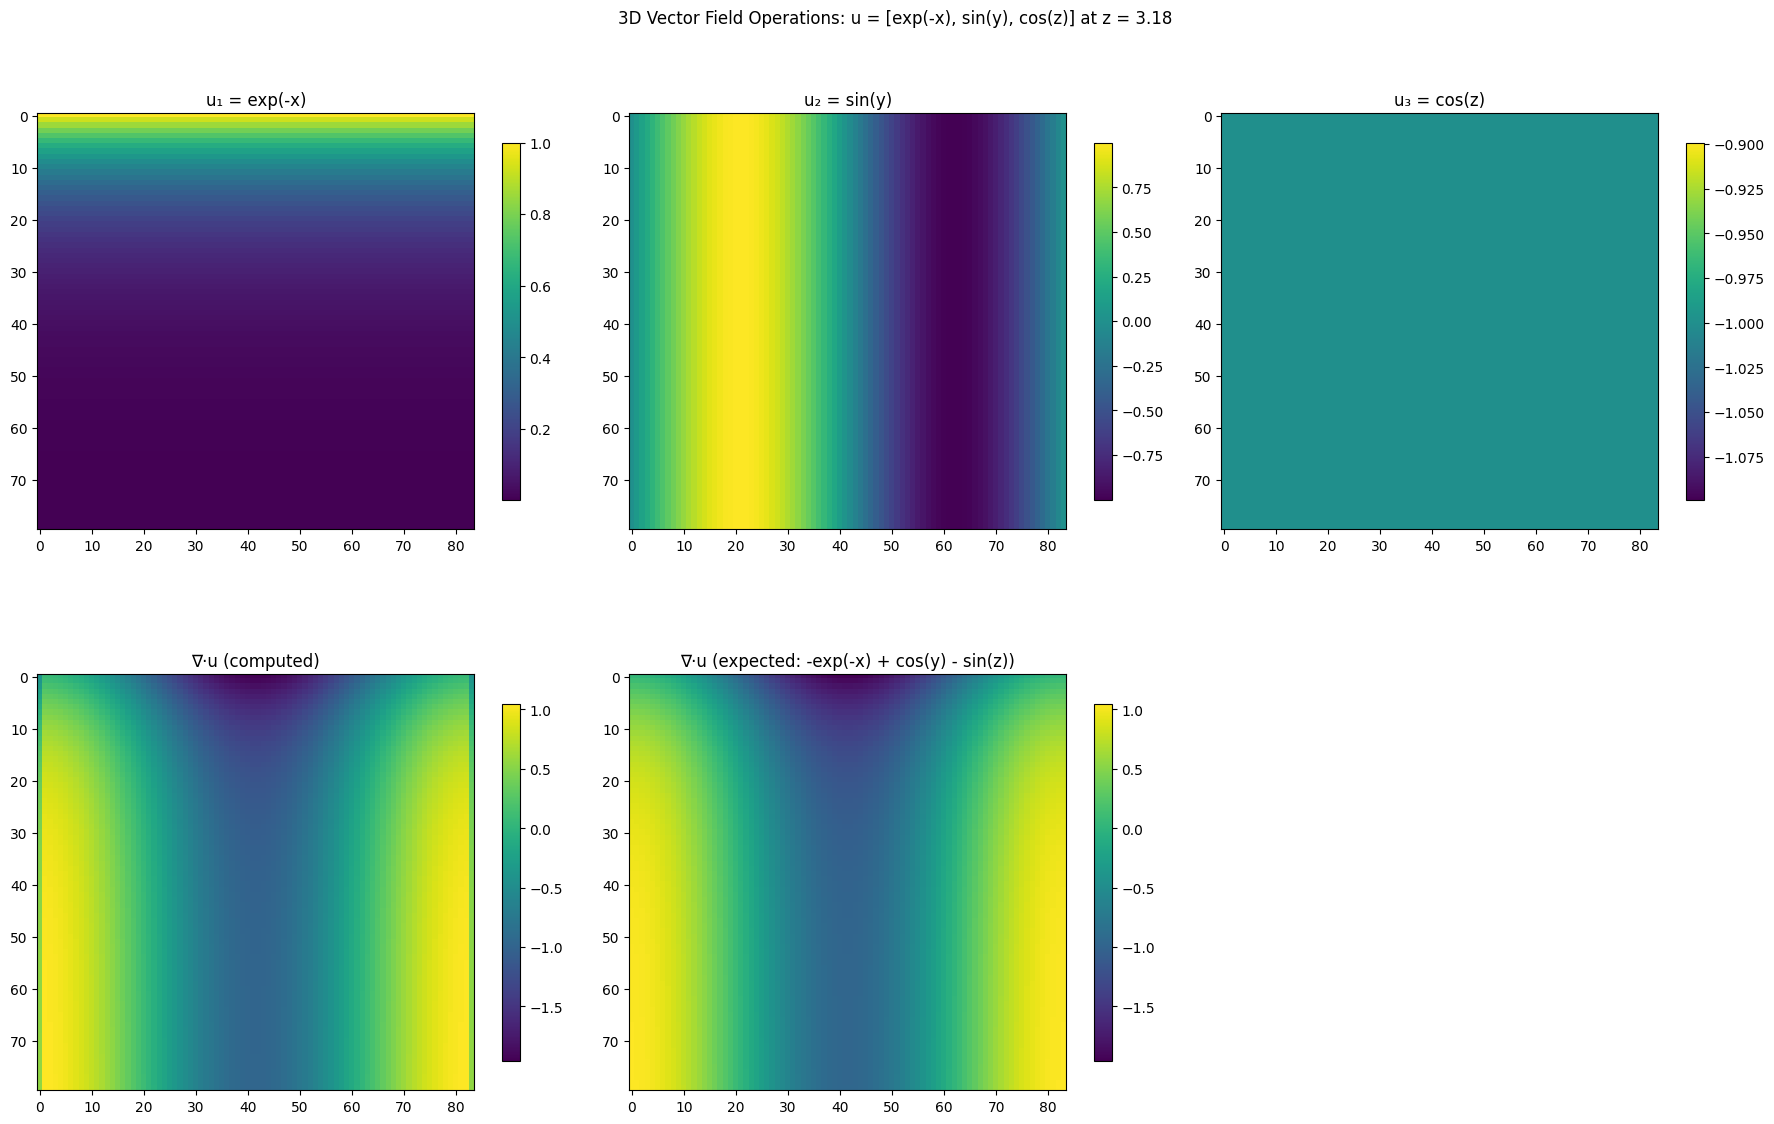

In [196]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'3D Vector Field Operations: u = [exp(-x), sin(y), cos(z)] at z = {z_slice_val:.2f}')

# Compute consistent colorbar limits for vector field components at z-slice
u1_3d_slice = u1_3d[:, :, z_slice_idx]
u2_3d_slice = u2_3d[:, :, z_slice_idx]
u3_3d_slice = u3_3d[:, :, z_slice_idx]

u1_3d_min = min(u1_3d_slice.min().item(), u1_3d_slice.max().item())
u1_3d_max = max(u1_3d_slice.min().item(), u1_3d_slice.max().item())
u2_3d_min = min(u2_3d_slice.min().item(), u2_3d_slice.max().item())
u2_3d_max = max(u2_3d_slice.min().item(), u2_3d_slice.max().item())
u3_3d_min = min(u3_3d_slice.min().item(), u3_3d_slice.max().item())
u3_3d_max = max(u3_3d_slice.min().item(), u3_3d_slice.max().item())

# Compute consistent colorbar limits for divergence at z-slice
div_3d_slice = divergence_3d[:, :, z_slice_idx]
div_3d_expected_slice = divergence_3d_expected[:, :, z_slice_idx]
div_3d_min = min(div_3d_slice.min().item(), div_3d_expected_slice.min().item())
div_3d_max = max(div_3d_slice.max().item(), div_3d_expected_slice.max().item())

# Vector field components
im0 = axes[0, 0].imshow(u1_3d_slice.cpu().numpy(), vmin=u1_3d_min, vmax=u1_3d_max)
axes[0, 0].set_title('u₁ = exp(-x)')
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

im1 = axes[0, 1].imshow(u2_3d_slice.cpu().numpy(), vmin=u2_3d_min, vmax=u2_3d_max)
axes[0, 1].set_title('u₂ = sin(y)')
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

im2 = axes[0, 2].imshow(u3_3d_slice.cpu().numpy(), vmin=u3_3d_min, vmax=u3_3d_max)
axes[0, 2].set_title('u₃ = cos(z)')
plt.colorbar(im2, ax=axes[0, 2], shrink=0.62)

# Divergence
im3 = axes[1, 0].imshow(div_3d_slice.cpu().numpy(), vmin=div_3d_min, vmax=div_3d_max)
axes[1, 0].set_title('∇·u (computed)')
plt.colorbar(im3, ax=axes[1, 0], shrink=0.62)

# Divergence expected
im4 = axes[1, 1].imshow(div_3d_expected_slice.cpu().numpy(), vmin=div_3d_min, vmax=div_3d_max)
axes[1, 1].set_title('∇·u (expected: -exp(-x) + cos(y) - sin(z))')
plt.colorbar(im4, ax=axes[1, 1], shrink=0.62)

# Empty plot for symmetry
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()

# Models

## Example 12: Training a SFNO on the spherical Shallow Water equations

In [197]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import SFNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_spherical_swe
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [198]:
train_loader, test_loaders = load_spherical_swe(n_train=200, batch_size=4, train_resolution=(32, 64),
                                                test_resolutions=[(32, 64), (64, 128)], n_tests=[50, 50], test_batch_sizes=[10, 10],)

Loading train dataloader at resolution (32, 64) with 200 samples and batch-size=4
Loading test dataloader at resolution (32, 64) with 50 samples and batch-size=10
Loading test dataloader at resolution (64, 128) with 50 samples and batch-size=10


In [199]:
model = SFNO(n_modes=(32, 32),
             in_channels=3,
             out_channels=3,
             hidden_channels=32,
             projection_channel_ratio=2,
             factorization='dense')
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 275555 parameters.


In [200]:
optimizer = AdamW(model.parameters(),
                                lr=8e-4,
                                weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [201]:
l2loss = LpLoss(d=2, p=2, reduction='sum')

train_loss = l2loss
eval_losses={'l2': l2loss} #'h1': h1loss,

In [202]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 SFNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SphericalConv(
        (weight): ComplexDenseTensor(shape=torch.Size([32, 32, 32]), rank=None)
        (sht_handle): SHT(
          (_SHT_cache): ModuleDict()
          (_iSHT_cache): ModuleDict()
        )
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(5, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projectio

In [203]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

In [204]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 200 samples
Testing on [50, 50] samples         on resolutions [(32, 64), (64, 128)].
Raw outputs of shape torch.Size([4, 3, 32, 64])
[0] time=23.71, avg_loss=2.6891, train_err=10.7565
Eval: (32, 64)_l2=2.2267, (64, 128)_l2=2.4824
[3] time=16.41, avg_loss=0.4125, train_err=1.6499
Eval: (32, 64)_l2=0.6613, (64, 128)_l2=2.7407
[6] time=16.31, avg_loss=0.2713, train_err=1.0852
Eval: (32, 64)_l2=0.4297, (64, 128)_l2=2.5995
[9] time=16.05, avg_loss=0.2094, train_err=0.8377
Eval: (32, 64)_l2=0.3256, (64, 128)_l2=2.5196
[12] time=16.67, avg_loss=0.1830, train_err=0.7318
Eval: (32, 64)_l2=0.2638, (64, 128)_l2=2.4551
[15] time=16.78, avg_loss=0.1525, train_err=0.6098
Eval: (32, 64)_l2=0.2086, (64, 128)_l2=2.4375
[18] time=16.21, avg_loss=0.1401, train_err=0.5604
Eval: (32, 64)_l2=0.2082, (64, 128)_l2=2.4357


{'train_err': 0.549316817522049,
 'avg_loss': 0.13732920438051224,
 'avg_lasso_loss': None,
 'epoch_train_time': 15.483141399978194}

C:\Users\eamor\AppData\Local\Temp\ipykernel_41656\2782922215.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


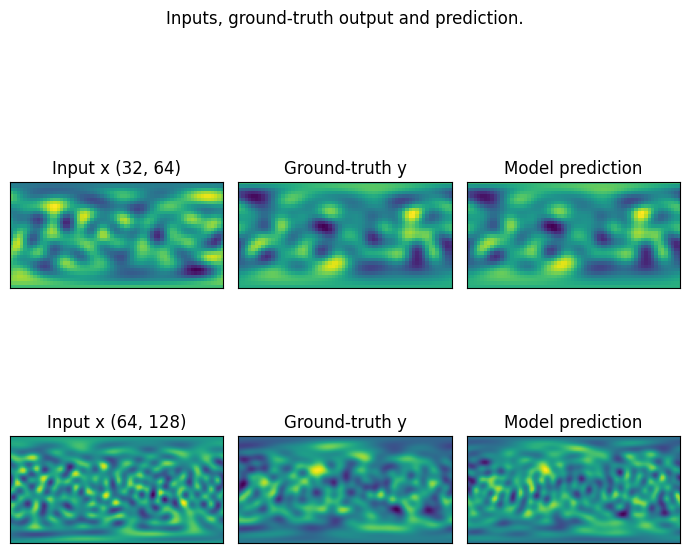

In [205]:
fig = plt.figure(figsize=(7, 7))
for index, resolution in enumerate([(32, 64), (64, 128)]):
    test_samples = test_loaders[resolution].dataset
    data = test_samples[0]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y'][0, ...].numpy()
    # Model prediction
    x_in = x.unsqueeze(0).to(device)
    out = model(x_in).squeeze()[0, ...].detach().cpu().numpy()
    x = x[0, ...].detach().numpy()

    ax = fig.add_subplot(2, 3, index*3 + 1)
    ax.imshow(x)
    ax.set_title(f'Input x {resolution}')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 2)
    ax.imshow(y)
    ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 3)
    ax.imshow(out)
    ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

## Example 13: U-NO on Darcy-Flow

In [206]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import UNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

In [207]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
        data_root = './'
)

model = UNO(in_channels=1,
            out_channels=1,
            hidden_channels=64,
            projection_channels=64,
            uno_out_channels=[32,64,64,64,32],
            uno_n_modes=[[16,16],[8,8],[8,8],[8,8],[16,16]],
            uno_scalings=[[1.0,1.0],[0.5,0.5],[1,1],[2,2],[1,1]],
            horizontal_skips_map=None,
            channel_mlp_skip="linear",
            n_layers = 5,
            domain_padding=0.2)

model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'

Our model has 2700097 parameters.


c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:122: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  data["x"][train_input_indices].unsqueeze(channel_dim).type(torch.float32).clone()
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:125: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in

In [208]:
optimizer = AdamW(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [209]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [210]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 UNO(
  (positional_embedding): GridEmbeddingND()
  (domain_padding): DomainPadding()
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (fno_blocks): ModuleList(
    (0): FNOBlocks(
      (convs): ModuleList(
        (0): SpectralConv(
          (weight): DenseTensor(shape=torch.Size([64, 32, 16, 9]), rank=None)
        )
      )
      (fno_skips): ModuleList(
        (0): Flattened1dConv(
          (conv): Conv1d(64, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
      )
      (channel_mlp): ModuleList(
        (0): ChannelMLP(
          (fcs): ModuleList(
            (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
            (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
          )
        )
      )
      (channel_mlp_skips): ModuleList(
        (0): Flattened1dConv(
          (conv): Conv1d(64, 32, kernel_size=(1,), stride=(1,

In [211]:
trainer = Trainer(model=model,
                   n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

In [212]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].


c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\tltorch\factorized_tensors\factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  return self.__class__(self.tensor[indices])
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\layers\spectral_convolution.py:468: UserWarning: Using a non-tuple s

Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=16.86, avg_loss=0.6897, train_err=21.5544
Eval: 16_h1=0.3886, 16_l2=0.2572, 32_h1=0.8965, 32_l2=0.6320
[3] time=16.44, avg_loss=0.2360, train_err=7.3764
Eval: 16_h1=0.3093, 16_l2=0.2261, 32_h1=0.8020, 32_l2=0.5739
[6] time=16.10, avg_loss=0.2352, train_err=7.3513
Eval: 16_h1=0.2820, 16_l2=0.1825, 32_h1=0.7690, 32_l2=0.5186
[9] time=16.09, avg_loss=0.1917, train_err=5.9900
Eval: 16_h1=0.2950, 16_l2=0.1828, 32_h1=0.7647, 32_l2=0.5194
[12] time=18.54, avg_loss=0.1913, train_err=5.9790
Eval: 16_h1=0.3068, 16_l2=0.2168, 32_h1=0.7340, 32_l2=0.4973
[15] time=16.55, avg_loss=0.1691, train_err=5.2831
Eval: 16_h1=0.2624, 16_l2=0.1605, 32_h1=0.7225, 32_l2=0.4478
[18] time=17.92, avg_loss=0.1406, train_err=4.3945
Eval: 16_h1=0.2363, 16_l2=0.1488, 32_h1=0.7205, 32_l2=0.4674


{'train_err': 3.74998277798295,
 'avg_loss': 0.11999944889545441,
 'avg_lasso_loss': None,
 'epoch_train_time': 19.30643489997601}

c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\tltorch\factorized_tensors\factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  return self.__class__(self.tensor[indices])
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\layers\spectral_convolution.py:468: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different

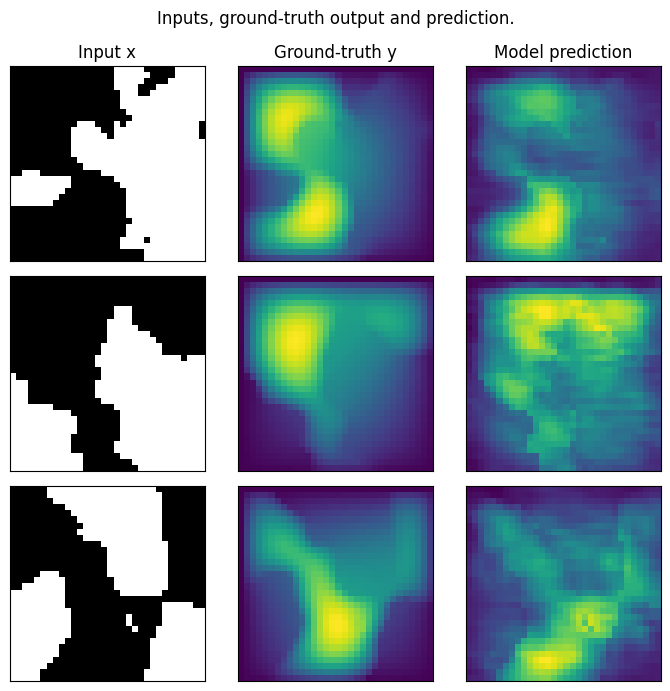

In [213]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0).to(device)).cpu()

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

## Example 14: Training an FNO on Darcy-Flow

In [214]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

In [215]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
        data_root = './'
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:122: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  data["x"][train_input_indices].unsqueeze(channel_dim).type(torch.float32).clone()
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:125: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in

In [216]:
model = FNO(n_modes=(16, 16),
             in_channels=1,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


In [217]:
optimizer = AdamW(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [218]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [219]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 

In [220]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

In [221]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([32, 1, 16, 16])


c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\tltorch\factorized_tensors\factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  return self.__class__(self.tensor[indices])
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\layers\spectral_convolution.py:468: UserWarning: Using a non-tuple s

[0] time=11.35, avg_loss=0.7009, train_err=21.9037
Eval: 16_h1=0.4288, 16_l2=0.2953, 32_h1=0.6012, 32_l2=0.2969
[3] time=10.41, avg_loss=0.2183, train_err=6.8205
Eval: 16_h1=0.2064, 16_l2=0.1436, 32_h1=0.5098, 32_l2=0.1823
[6] time=10.14, avg_loss=0.1924, train_err=6.0122
Eval: 16_h1=0.2063, 16_l2=0.1380, 32_h1=0.5240, 32_l2=0.1771
[9] time=17.46, avg_loss=0.1545, train_err=4.8278
Eval: 16_h1=0.2041, 16_l2=0.1297, 32_h1=0.5317, 32_l2=0.1734
[12] time=10.37, avg_loss=0.1558, train_err=4.8697
Eval: 16_h1=0.2337, 16_l2=0.1536, 32_h1=0.5918, 32_l2=0.2011
[15] time=9.98, avg_loss=0.1056, train_err=3.2997
Eval: 16_h1=0.1985, 16_l2=0.1126, 32_h1=0.5335, 32_l2=0.1590
[18] time=9.75, avg_loss=0.1140, train_err=3.5632
Eval: 16_h1=0.2077, 16_l2=0.1198, 32_h1=0.5748, 32_l2=0.1715


{'train_err': 3.13584147952497,
 'avg_loss': 0.10034692734479904,
 'avg_lasso_loss': None,
 'epoch_train_time': 10.142939799989108}

c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\tltorch\factorized_tensors\factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  return self.__class__(self.tensor[indices])
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\layers\spectral_convolution.py:468: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different

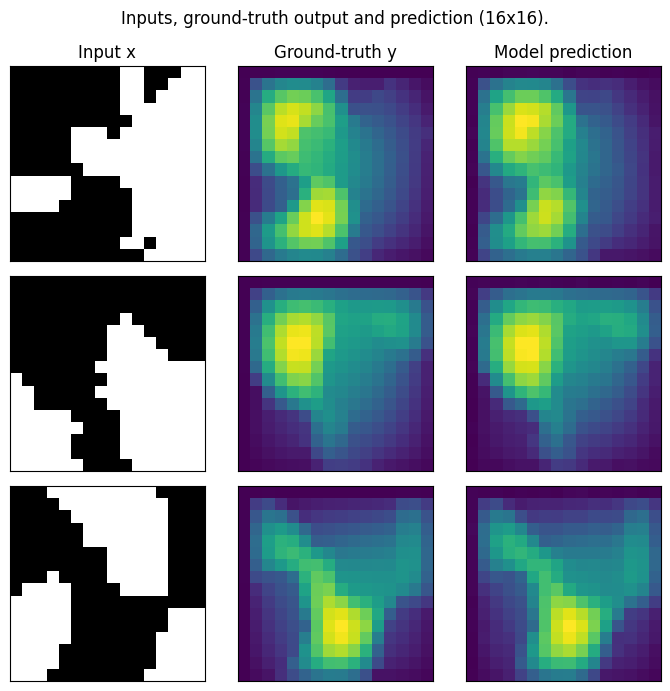

In [222]:
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
fig.show()


In addition to training and making predictions on the same input size, the FNO’s invariance to the discretization of input data means we can natively make predictions on higher-resolution inputs and get higher-resolution outputs.

c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\tltorch\factorized_tensors\factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  return self.__class__(self.tensor[indices])
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\layers\spectral_convolution.py:468: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different

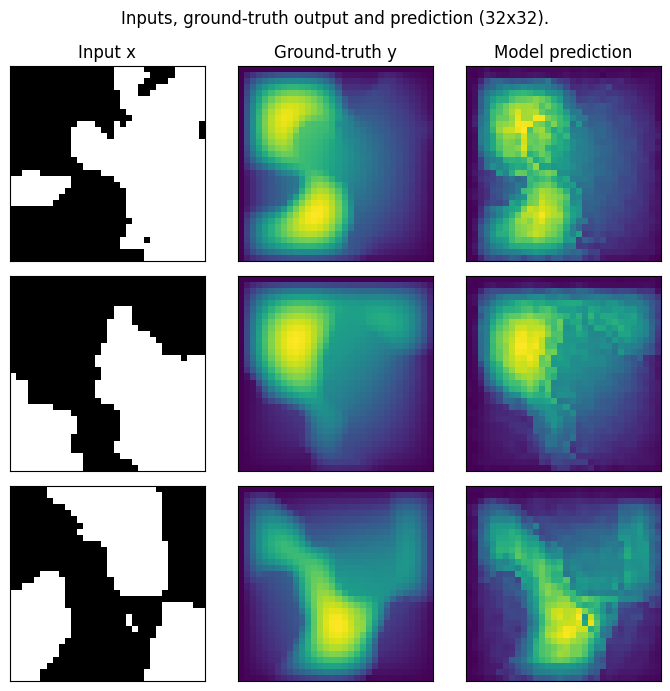

In [223]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (32x32).', y=0.98)
plt.tight_layout()
fig.show()

# Training and Meta-Algorithms

## Example 15: Using torchtnt to count FLOPS

In [ ]:
from copy import deepcopy
import torch
from torchtnt.utils.flops import FlopTensorDispatchMode

from neuralop.models import FNO

device = 'cpu'

fno = FNO(n_modes=(64,64),
          in_channels=1,
          out_channels=1,
          hidden_channels=64,
          projection_channel_ratio=1)

batch_size = 4
model_input = torch.randn(batch_size, 1, 128, 128)


with FlopTensorDispatchMode(fno) as ftdm:
    # count forward flops
    res = fno(model_input).mean()
    fno_forward_flops = deepcopy(ftdm.flop_counts)

    ftdm.reset()
    res.backward()
    fno_backward_flops = deepcopy(ftdm.flop_counts)

c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchtnt\utils\version.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
W1013 02:48:39.445000 41656 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\tltorch\factorized_tensors\factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_w

In [ ]:
print(fno_forward_flops)

defaultdict(<function FlopTensorDispatchMode.__init__.<locals>.<lambda> at 0x000001D05E9C6520>, {'': defaultdict(<class 'int'>, {'convolution.default': 2982150144, 'bmm.default': 138412032}), 'lifting': defaultdict(<class 'int'>, {'convolution.default': 562036736}), 'lifting.fcs.0': defaultdict(<class 'int'>, {'convolution.default': 25165824}), 'lifting.fcs.1': defaultdict(<class 'int'>, {'convolution.default': 536870912}), 'fno_blocks': defaultdict(<class 'int'>, {'convolution.default': 2147483648, 'bmm.default': 138412032}), 'fno_blocks.fno_skips.0': defaultdict(<class 'int'>, {'convolution.default': 268435456}), 'fno_blocks.fno_skips.0.conv': defaultdict(<class 'int'>, {'convolution.default': 268435456}), 'fno_blocks.convs.0': defaultdict(<class 'int'>, {'bmm.default': 34603008}), 'fno_blocks.channel_mlp.0': defaultdict(<class 'int'>, {'convolution.default': 268435456}), 'fno_blocks.channel_mlp.0.fcs.0': defaultdict(<class 'int'>, {'convolution.default': 134217728}), 'fno_blocks.cha

In [ ]:
from collections import defaultdict
def get_max_flops(flop_count_dict, max_value = 0):
    for _, value in flop_count_dict.items():
        # if not nested, compare leaf value to max
        if isinstance(value, int):
            max_value = max(max_value, value)

        # otherwise compute recursive max value below node
        elif isinstance(value, defaultdict):
            new_val = get_max_flops(value, max_value)
            max_value = max(max_value, new_val)
    return max_value

print(f"Max FLOPS required for FNO.forward: {get_max_flops(fno_forward_flops)}")
print(f"Max FLOPS required for FNO.backward: {get_max_flops(fno_backward_flops)}")

Max FLOPS required for FNO.forward: 2982150144
Max FLOPS required for FNO.backward: 5939134464


## Example 16: Checkpointing and loading training states

In [237]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

In [238]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
        data_root = './'
)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


In [239]:
model = FNO(n_modes=(16, 16),
             in_channels=1,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2,
             factorization='tucker',
             rank=0.42)

model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 520761 parameters.


In [240]:
optimizer = AdamW(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [241]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [242]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): TuckerTensor(shape=(32, 32, 16, 9), rank=(26, 26, 13, 7))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 

In [243]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

In [244]:
trainer.train(train_loader=train_loader,
              test_loaders={},
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              save_every=1,
              save_dir="./checkpoints")

Training on 1000 samples
Testing on [] samples         on resolutions [].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=10.93, avg_loss=0.6023, train_err=18.8230
Eval: 
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[3] time=26.14, avg_loss=0.2368, train_err=7.3995
Eval: 
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[6] time=26.16, avg_loss=0.1920, train_err=5.9996
Eval: 
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[9] time=26.93, avg_loss=0.1790, train_err=5.5941
Eval: 
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[12] time=26.30, avg_loss=0.1647, train_err=5.1462
Eval: 
[Rank 0]: save

{'train_err': 4.517031278461218,
 'avg_loss': 0.14454500091075898,
 'avg_lasso_loss': None,
 'epoch_train_time': 22.475053400034085}

In [245]:
# .. resume_from_dir:
# resume training from saved checkpoint at epoch 10

trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders={},
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              resume_from_dir="./checkpoints")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch._C._nn.gelu was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch._C._nn.gelu])` or the `torch.serialization.safe_globals([torch._C._nn.gelu])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

## Example 17: Training an FNO with incremental meta-learning

In [246]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.training import AdamW
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.data.transforms.data_processors import IncrementalDataProcessor
from neuralop import LpLoss, H1Loss

In [247]:
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    n_train=100,
    batch_size=16,
    test_resolutions=[16, 32],
    n_tests=[100, 50],
    test_batch_sizes=[32, 32],
    data_root="./"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


In [248]:
incremental = True
if incremental:
    starting_modes = (2, 2)
else:
    starting_modes = (16, 16)

In [249]:
model = FNO(
    max_n_modes=(16, 16),
    n_modes=starting_modes,
    hidden_channels=32,
    in_channels=1,
    out_channels=1,
)
model = model.to(device)
n_params = count_model_params(model)

In [250]:
optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


# If one wants to use Incremental Resolution, one should use the IncrementalDataProcessor - When passed to the trainer, the trainer will automatically update the resolution
# Incremental_resolution : bool, default is False
#    if True, increase the resolution of the input incrementally
#    uses the incremental_res_gap parameter
#    uses the subsampling_rates parameter - a list of resolutions to use
#    uses the dataset_indices parameter - a list of indices of the dataset to slice to regularize the input resolution
#    uses the dataset_resolution parameter - the resolution of the input
#    uses the epoch_gap parameter - the number of epochs to wait before increasing the resolution
#    uses the verbose parameter - if True, print the resolution and the number of modes
data_transform = IncrementalDataProcessor(
    in_normalizer=None,
    out_normalizer=None,
    device=device,
    subsampling_rates=[2, 1],
    dataset_resolution=16,
    dataset_indices=[2, 3],
    epoch_gap=10,
    verbose=True,
)

data_transform = data_transform.to(device)

Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8


In [251]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss = h1loss
eval_losses = {"h1": h1loss, "l2": l2loss}
print("\n### N PARAMS ###\n", n_params)
print("\n### OPTIMIZER ###\n", optimizer)
print("\n### SCHEDULER ###\n", scheduler)
print("\n### LOSSES ###")
print("\n### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###")
print(f"\n * Train: {train_loss}")
print(f"\n * Test: {eval_losses}")
sys.stdout.flush()


### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x000001D064166420>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x000001D064166420>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x000001D064167530>}


In [252]:
# Finally pass all of these to the Trainer
trainer = IncrementalFNOTrainer(
    model=model,
    n_epochs=20,
    data_processor=data_transform,
    device=device,
    verbose=True,
    incremental_loss_gap=False,
    incremental_grad=True,
    incremental_grad_eps=0.9999,
    incremental_loss_eps = 0.001,
    incremental_buffer=5,
    incremental_max_iter=1,
    incremental_grad_max_iter=2,
)

In [253]:
trainer.train(
    train_loader,
    test_loaders,
    optimizer,
    scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
)

Training on 100 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([16, 1, 8, 8])
[0] time=0.79, avg_loss=0.9383, train_err=13.4044
Eval: 16_h1=0.8861, 16_l2=0.5671, 32_h1=0.9302, 32_l2=0.5669
[1] time=0.85, avg_loss=0.8008, train_err=11.4404
Eval: 16_h1=0.8111, 16_l2=0.4515, 32_h1=0.9911, 32_l2=0.4697
[2] time=0.82, avg_loss=0.6711, train_err=9.5876
Eval: 16_h1=0.7808, 16_l2=0.4358, 32_h1=0.9442, 32_l2=0.4620
[3] time=0.93, avg_loss=0.6130, train_err=8.7574
Eval: 16_h1=0.8294, 16_l2=0.4815, 32_h1=1.1537, 32_l2=0.5311
[4] time=0.81, avg_loss=0.5826, train_err=8.3225
Eval: 16_h1=0.8895, 16_l2=0.5872, 32_h1=1.2792, 32_l2=0.6402
[5] time=0.70, avg_loss=0.5505, train_err=7.8642
Eval: 16_h1=0.7366, 16_l2=0.3826, 32_h1=1.0218, 32_l2=0.4123
[6] time=0.78, avg_loss=0.5101, train_err=7.2870
Eval: 16_h1=0.7833, 16_l2=0.4301, 32_h1=1.1190, 32_l2=0.4804
[7] time=0.59, avg_loss=0.4536, train_err=6.4800
Eval: 16_h1=0.6230, 16_l2=0.3273, 32_h1=0.9165,

{'train_err': 3.8160739796502248,
 'avg_loss': 0.26712517857551576,
 'avg_lasso_loss': None,
 'epoch_train_time': 1.2083757999935187,
 '16_h1': tensor(0.3133),
 '16_l2': tensor(0.2079),
 '32_h1': tensor(0.4523),
 '32_l2': tensor(0.2293)}

c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\tltorch\factorized_tensors\factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  return self.__class__(self.tensor[indices])
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\layers\spectral_convolution.py:468: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different

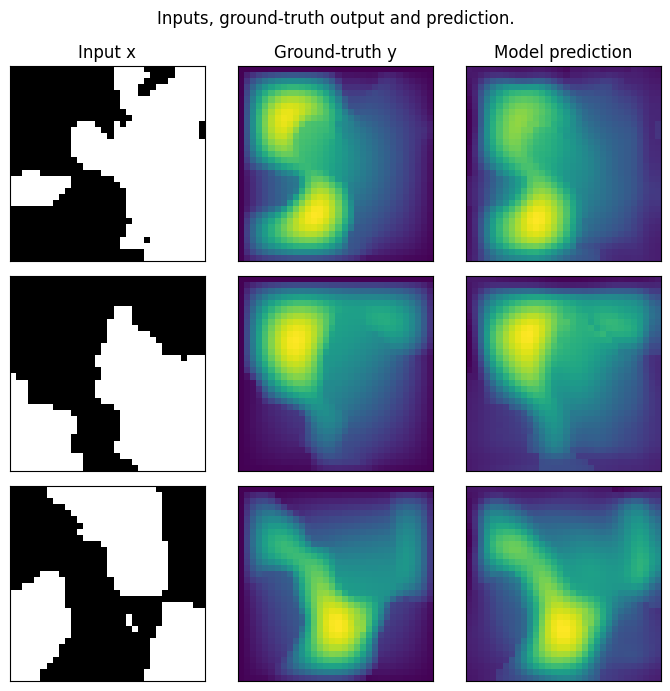

In [254]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data["x"].to(device)
    # Ground-truth
    y = data["y"].to(device)
    # Model prediction
    out = model(x.unsqueeze(0))
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    x = x.cpu().squeeze().detach().numpy()
    y = y.cpu().squeeze().detach().numpy()
    ax.imshow(x, cmap="gray")
    if index == 0:
        ax.set_title("Input x")
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index * 3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title("Ground-truth y")
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index * 3 + 3)
    ax.imshow(out.cpu().squeeze().detach().numpy())
    if index == 0:
        ax.set_title("Model prediction")
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle("Inputs, ground-truth output and prediction.", y=0.98)
plt.tight_layout()
fig.show()